In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import re
import string
from collections import Counter
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import networkx as nx

# **Spotify values**

In [2]:
#load dataset
file_path = '/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/taylor_swift_spotify.csv'
full_dataset = pd.read_csv(file_path)

#info on the full dataset
full_dataset.head(20)
full_dataset["album"].unique()

#transform the release_date column into date format
full_dataset["release_date"]=pd.to_datetime(full_dataset['release_date'])

#sort first main dataset by release date just to see how it looks like
full_dataset=full_dataset.sort_values(by='release_date')

#only keep main albums, delete deluxe versions or special albums
main_albums = full_dataset[~full_dataset['album'].isin(['Midnights (The Til Dawn Edition)', 'Midnights (3am Edition)','evermore (deluxe version)','folklore: the long pond studio sessions (from the Disney+ special) [deluxe edition]',
       'folklore (deluxe version)', 'reputation Stadium Tour Surprise Song Playlist', '1989 (Deluxe)','Red (Deluxe Edition)', 'Speak Now World Tour Live','Speak Now (Deluxe Package)',
       'Fearless (Platinum Edition)', 'Fearless (International Version)',
       'Live From Clear Channel Stripped 2008', "Speak Now"])]

#sort the main albums dataset by the release date
main_albums.sort_values(by="release_date")
main_albums.dtypes

main_albums["album"].unique()

array(['Taylor Swift', '1989', 'reputation', 'Lover', 'folklore',
       'evermore', "Fearless (Taylor's Version)",
       "Red (Taylor's Version)", 'Midnights',
       "Speak Now (Taylor's Version)"], dtype=object)

In [3]:
#change release date of the rereleased albums so that when i arrange the dataset by release date they are in the original order
main_albums.loc[main_albums['album'] == "Speak Now (Taylor's Version)", 'release_date'] = '2010-10-24'
main_albums.loc[main_albums['album'] == "Fearless (Taylor's Version)", 'release_date'] = '2008-11-11'
main_albums.loc[main_albums['album'] == "Red (Taylor's Version)", 'release_date'] = '2012-10-22'
main_albums=main_albums.sort_values(by="release_date")

pd.set_option('display.max_rows', main_albums.shape[0]+1)

## Songs' duration

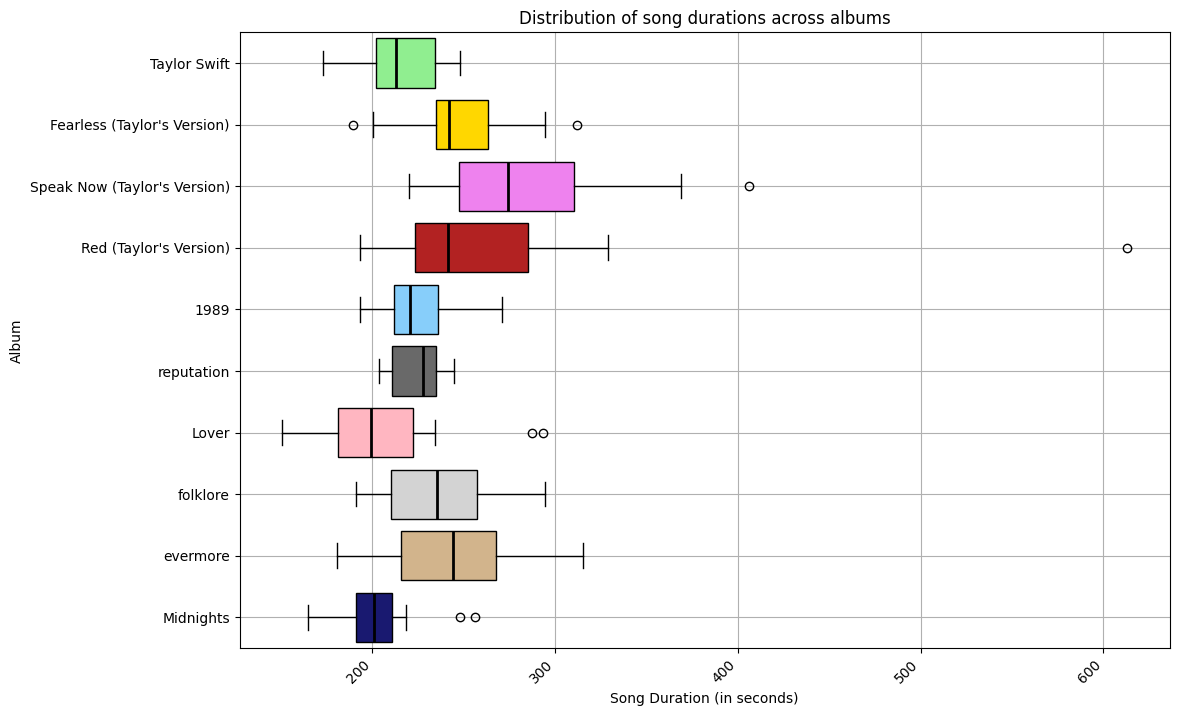

In [4]:
#create a copy of the original dataframe to avoid modifying it
duration_main_albums = main_albums.copy()

#convert 'duration_ms' to seconds
duration_main_albums['duration_sec'] = duration_main_albums['duration_ms'] / 1000

colors = ['lightgreen', 'gold', 'violet', 'firebrick', 'lightskyblue', "dimgrey", "lightpink", "lightgrey", "tan", "midnightblue"]
flipped_colors = ["midnightblue", "tan",  "lightgrey", "lightpink", "dimgrey", 'lightskyblue',  'firebrick', 'violet','gold','lightgreen']

#create a boxplot grouped by the "album" column with inclined labels
plt.figure(figsize=(12, 8))

#reverse the order of both data and labels
unique_albums = duration_main_albums['album'].unique()[::-1]
data_to_plot = [duration_main_albums[duration_main_albums['album'] == album]['duration_sec'] for album in unique_albums]

box = plt.boxplot(data_to_plot,
                  labels=unique_albums,
                  vert=False,  #for horizontal boxplot
                  widths=0.80,
                  patch_artist=True)  #for filling boxes with color

#set individual box colors
for patch, color in zip(box['boxes'], flipped_colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set(color='black', linewidth=2) 

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

plt.title('Distribution of song durations across albums')
plt.xlabel('Song Duration (in seconds)')
plt.ylabel('Album')
plt.grid(True)
plt.show()

## Popularity
The popularity of the song from 0 to 100.
The popularity is determined by an algorithm and is based primarily on the total number of plays the track has received and how recent those plays are. In general, songs that are being played a lot now will be more popular than songs that were played a lot in the past. Track popularity is used to calculate artist and album popularity.

In [5]:
#measure the average popularity of each album
average_popularity_by_album = main_albums.groupby('album')['popularity'].mean().reset_index()
average_popularity_by_album.sort_values(by="popularity", ascending=False)

#add the column with the release dates
release_dates_subset = main_albums[['album', 'release_date']].drop_duplicates()
average_popularity_by_album=pd.merge(average_popularity_by_album, release_dates_subset, on="album")

#sort the dataframe by the date
average_popularity_by_album=average_popularity_by_album.sort_values("release_date")
average_popularity_by_album["popularity"]=average_popularity_by_album["popularity"]/100 #divided this value by 100 to make it comparable with other values later
average_popularity_by_album

,album,popularity,release_date
6,Taylor Swift,0.598000,2006-10-24
1,Fearless (Taylor's Version),0.703077,2008-11-11
5,Speak Now (Taylor's Version),0.793636,2010-10-24
4,Red (Taylor's Version),0.727667,2012-10-22
0,1989,0.646154,2014-01-01
9,reputation,0.812000,2017-11-10
2,Lover,0.812778,2019-08-23
8,folklore,0.780625,2020-07-24
7,evermore,0.719333,2020-12-11
3,Midnights,0.810000,2022-10-21


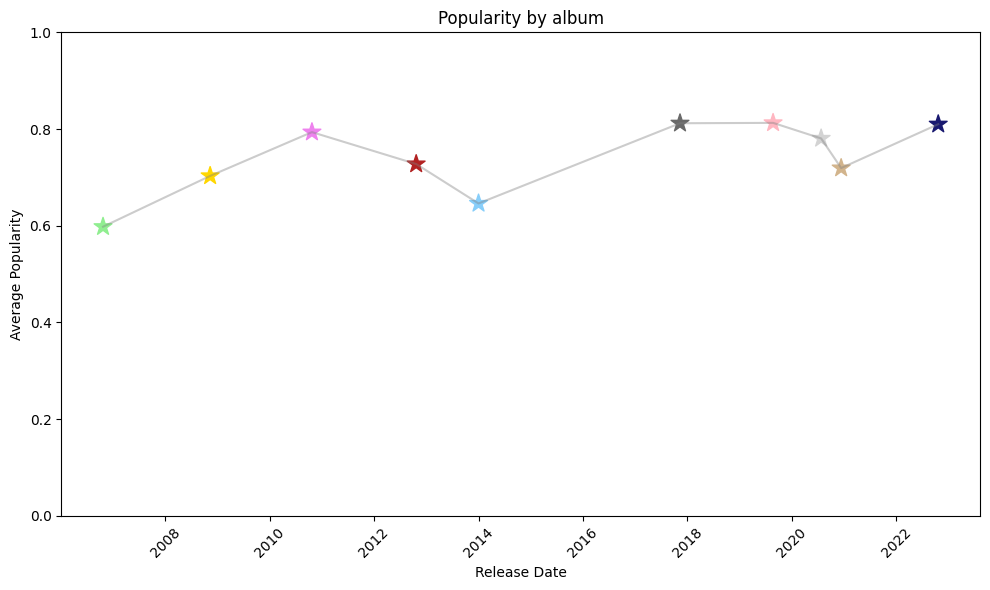

In [6]:
#plotting as a scatter plot with lines connecting consecutive points
plt.figure(figsize=(10, 6))

#scatter plot with manually chosen colors
plt.scatter(average_popularity_by_album['release_date'], average_popularity_by_album['popularity'], color=colors, label='Popularity', s=180, marker="*")

#line plot connecting consecutive points
plt.plot(average_popularity_by_album['release_date'], average_popularity_by_album['popularity'], '-', color='gray', alpha=0.4)

plt.ylim(0, 1)
plt.title('Popularity by album')
plt.xlabel('Release Date')
plt.ylabel('Average Popularity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Danceability
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

In [7]:
#measure the average danceability of each album
average_danceability_by_album = main_albums.groupby('album')['danceability'].mean().reset_index()

#add the column with the release dates
average_danceability_by_album=pd.merge(average_danceability_by_album, release_dates_subset, on="album").sort_values("release_date")
average_danceability_by_album

,album,danceability,release_date
6,Taylor Swift,0.545267,2006-10-24
1,Fearless (Taylor's Version),0.551038,2008-11-11
5,Speak Now (Taylor's Version),0.551364,2010-10-24
4,Red (Taylor's Version),0.576967,2012-10-22
0,1989,0.650231,2014-01-01
9,reputation,0.657933,2017-11-10
2,Lover,0.658222,2019-08-23
8,folklore,0.567875,2020-07-24
7,evermore,0.518867,2020-12-11
3,Midnights,0.638538,2022-10-21


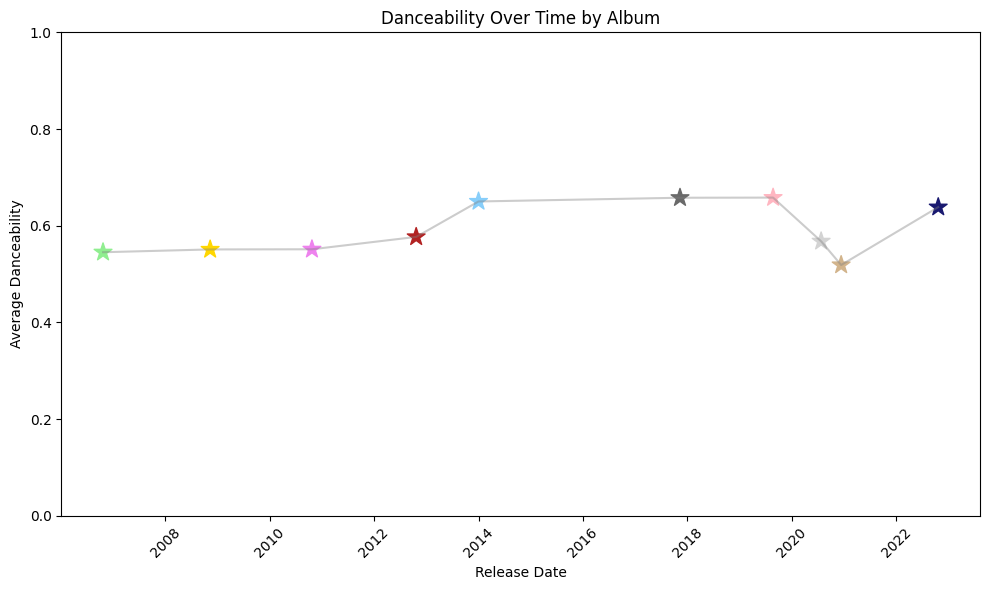

In [8]:
#plotting as a scatter plot with lines connecting consecutive points
plt.figure(figsize=(10, 6))

#scatter plot with manually chosen colors
plt.scatter(average_danceability_by_album['release_date'], average_danceability_by_album['danceability'], color=colors, label='Danceability', s=180, marker="*")

#line plot connecting consecutive points
plt.plot(average_danceability_by_album['release_date'], average_danceability_by_album['danceability'], '-', color='gray', alpha=0.4)

plt.ylim(0, 1)
plt.title('Danceability Over Time by Album')
plt.xlabel('Release Date')
plt.ylabel('Average Danceability')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Popularity vs Danceability

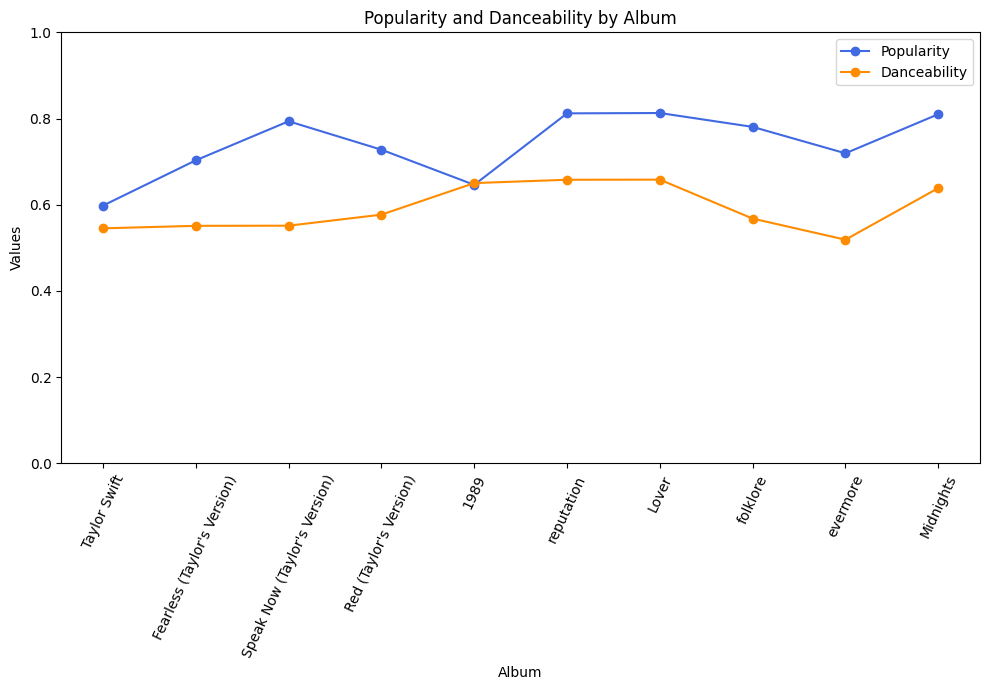

In [9]:
#plotting as a scatter plot with lines connecting consecutive points
plt.figure(figsize=(10, 7))

#plot the first line
plt.plot(average_popularity_by_album['album'], average_popularity_by_album['popularity'], 'o-', label='Popularity', color='royalblue')

#plot the second line
plt.plot(average_danceability_by_album['album'], average_danceability_by_album['danceability'], 'o-', label='Danceability', color='darkorange')

plt.ylim(0, 1)
plt.title('Popularity and Danceability by Album')
plt.xlabel('Album')
plt.ylabel('Values')
plt.xticks(rotation=65)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
#create a dataframe for danceability and popularity
merged_danceabilitypopularity = pd.merge(average_popularity_by_album, average_danceability_by_album, on='album')
merged_danceabilitypopularity.drop(columns='release_date_y', inplace=True)
merged_danceabilitypopularity.rename(columns={'release_date_x': 'release_date'}, inplace=True)

#calculate the correlation 
correlation = print("Correlation between danceability and popularity:", merged_danceabilitypopularity['danceability'].corr(merged_danceabilitypopularity['popularity']))


Correlation between danceability and popularity: 0.3867411545210111


## Valence

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [11]:
#measure the average valence of each album
average_valence_by_album = main_albums.groupby('album')['valence'].mean().reset_index()

#add the column with the release dates
average_valence_by_album=pd.merge(average_valence_by_album, release_dates_subset, on="album").sort_values("release_date")

#calculate the average valence
print("Overall average valence:",average_valence_by_album['valence'].mean())

average_valence_by_album

Overall average valence: 0.3936971134421134


,album,valence,release_date
6,Taylor Swift,0.426533,2006-10-24
1,Fearless (Taylor's Version),0.421923,2008-11-11
5,Speak Now (Taylor's Version),0.401782,2010-10-24
4,Red (Taylor's Version),0.424600,2012-10-22
0,1989,0.461908,2014-01-01
9,reputation,0.293400,2017-11-10
2,Lover,0.481444,2019-08-23
8,folklore,0.381250,2020-07-24
7,evermore,0.420600,2020-12-11
3,Midnights,0.223531,2022-10-21


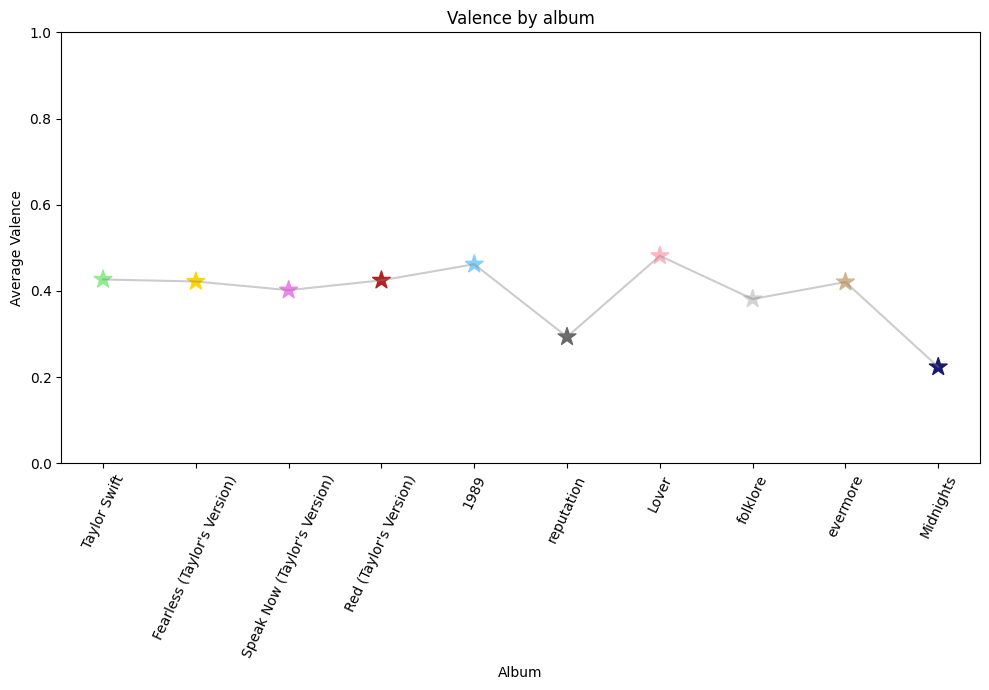

In [12]:
#plotting as a scatter plot with lines connecting consecutive points
plt.figure(figsize=(10, 7))

#scatter plot with manually chosen colors
plt.scatter(average_valence_by_album['album'], average_valence_by_album['valence'], color=colors, label='Valence', s=180, marker="*")

#line plot connecting consecutive points
plt.plot(average_valence_by_album['album'], average_valence_by_album['valence'], '-', color='gray', alpha=0.4)

plt.ylim(0, 1)
plt.title('Valence by album')
plt.xlabel('Album')
plt.ylabel('Average Valence')
plt.xticks(rotation=65)
plt.tight_layout()
plt.show()

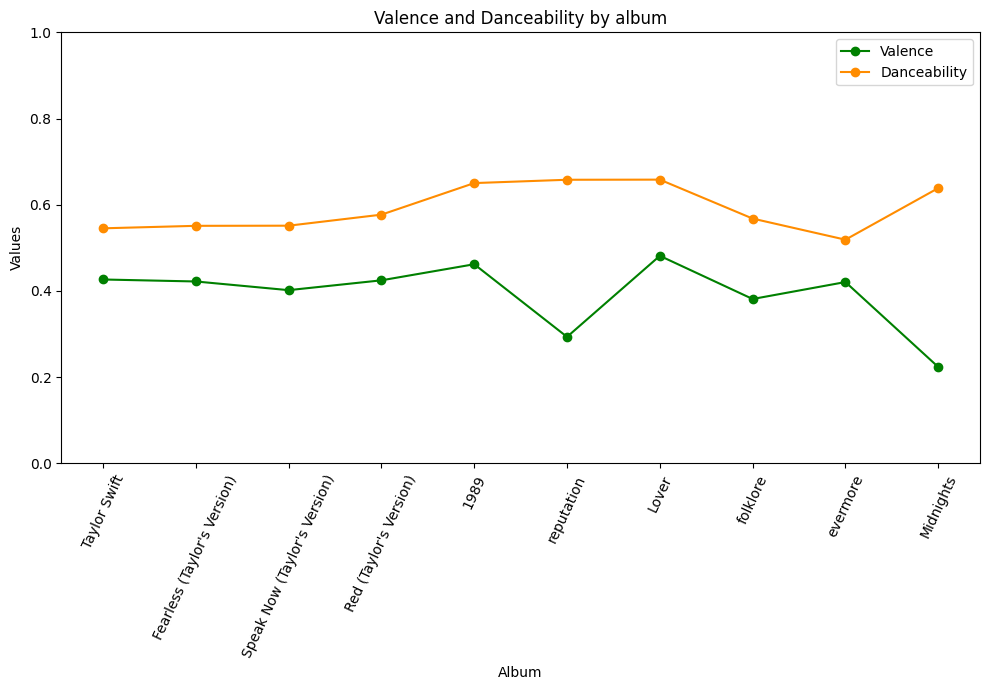

In [13]:
#plotting as a scatter plot with lines connecting consecutive points
plt.figure(figsize=(10, 7))

#plot the first line
plt.plot(average_valence_by_album['album'], average_valence_by_album['valence'], 'o-', label='Valence', color='green')

#plot the second line
plt.plot(average_danceability_by_album['album'], average_danceability_by_album['danceability'], 'o-', label='Danceability', color='darkorange')

plt.ylim(0, 1)
plt.title('Valence and Danceability by album')
plt.xlabel('Album')
plt.ylabel('Values')
plt.xticks(rotation=65)
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
#create a dataframe for danceability and valence 
merged_danceabilityvalence = pd.merge(average_valence_by_album, average_danceability_by_album, on='album')
merged_danceabilityvalence.drop(columns='release_date_y', inplace=True)
merged_danceabilityvalence.rename(columns={'release_date_x': 'release_date'}, inplace=True)

#calculate the correlation
correlation = print("Correlation between danceability and valence:", merged_danceabilityvalence['danceability'].corr(merged_danceabilityvalence['valence']))

Correlation between danceability and valence: -0.26168652259481845


In [15]:
#create a dataframe for valence and popularity
merged_valecepopularity = pd.merge(average_valence_by_album, average_popularity_by_album, on='album')
merged_valecepopularity.drop(columns='release_date_y', inplace=True)
merged_valecepopularity.rename(columns={'release_date_x': 'release_date'}, inplace=True)

#calculate the correlation
correlation = print("Correlation between valence and popularity:", merged_valecepopularity['valence'].corr(merged_valecepopularity['popularity']))

Correlation between valence and popularity: -0.4885472991129569


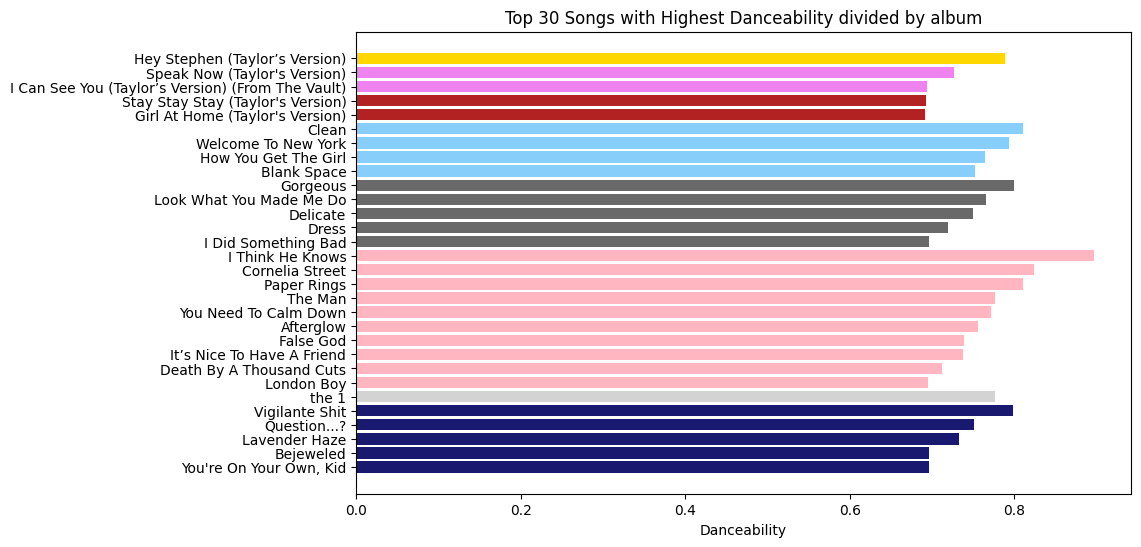

In [16]:
#create a df with the top 30 most danceable songs
top_danceability=main_albums.sort_values("danceability", ascending=False).head(30)

#manually specifying colors for each album
color_dict = {
    'Taylor Swift': 'lightgreen',
    "Fearless (Taylor's Version)": 'gold',
    "Speak Now (Taylor's Version)": 'violet',
    "Red (Taylor's Version)": 'firebrick',
    '1989': 'lightskyblue',
    'reputation': 'dimgrey',
    'Lover':'lightpink',
    'folklore': 'lightgrey',
    'evermore': 'tan',
    'Midnights': 'midnightblue'
}

#plot for top 30 most danceable songs
plt.figure(figsize=(10, 6))
for album, color in color_dict.items():
    album_songs = top_danceability[top_danceability['album'] == album]
    plt.barh(album_songs['name'], album_songs['danceability'], color=color, label=album)

plt.xlabel('Danceability')
plt.title('Top 30 Songs with Highest Danceability divided by album')
plt.gca().invert_yaxis()
plt.show()

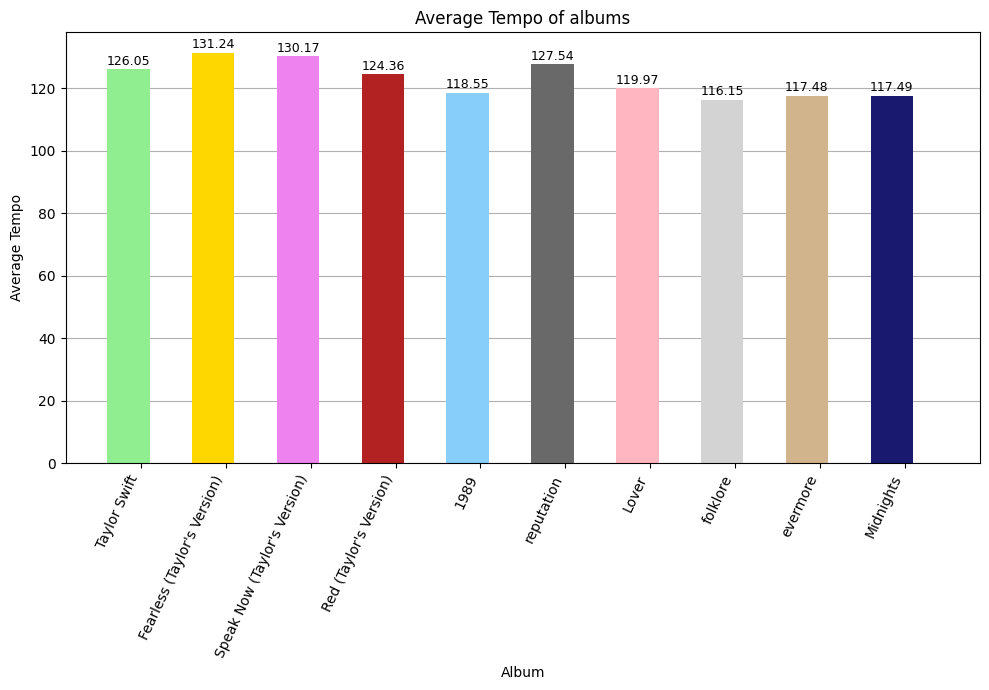

In [17]:
#calculate average tempo by album
average_tempo_by_album = main_albums.groupby('album')['tempo'].mean().reset_index()

#add release dates
average_tempo_by_album=pd.merge(average_tempo_by_album, release_dates_subset, on="album").sort_values("tempo")
average_tempo_by_album=average_tempo_by_album.sort_values(by="release_date")

#bar plot of the average tempo by album
plt.figure(figsize=(10, 7))
bars = plt.bar(average_tempo_by_album['album'], average_tempo_by_album['tempo'], color=colors)

#add label on top of the bar
for bar, tempo in zip(bars, average_tempo_by_album['tempo']):
    bar.set_width(0.5)
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f'{tempo:.2f}', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=65, ha='right')

plt.ylabel('Average Tempo')
plt.xlabel('Album')
plt.title('Average Tempo of albums')

plt.grid(axis='y')

#putting grid lines behind bars
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.show()

# **Lyrics Analysis**

In [18]:
def process_lyrics(file_path):
    with open(file_path, 'r', errors = 'ignore') as file:
        lyrics = file.read()
    
    #process the lyrics: lowercase, remove text in brackets, empty lines, and punctuation
    processed_lyrics = [
        line.strip().lower()  # lowercase all the words and delete white spaces
        for line in re.sub(r'\[.*?\]', '', lyrics).split('\n')[1:]  # remove text in square brackets, split by line
        if line.strip()  # remove empty lines
    ]
    
    #remove punctuation
    processed_lyrics = [line.translate(str.maketrans('', '', string.punctuation)) for line in processed_lyrics]
    
    #transform list of lines to a single string
    return ' '.join(processed_lyrics)

### Taylor Swift (Debut)

In [61]:
#process each song
aperfectlygoodheart_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/APerfectlyGoodHeart.txt")
aplaceinthisworld_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/APlaceInThisWorld.txt")
coldasyou_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/ColdasYou.txt")
imonlymewhenimwithyou_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/ImOnlyMeWhenImWithYou.txt")
invisible_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/Invisible.txt")
maryssong_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/MarysSong_OhMyMyMy_.txt")
oursong_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/OurSong.txt")
picturetoburn_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/PicturetoBurn.txt")
shouldvesaidno_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/ShouldveSaidNo.txt")
staybeautiful_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/StayBeautiful.txt")
teardropsonmyguitar_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/TeardropsOnMyGuitar.txt")
theoutside_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/TheOutside.txt")
tiedtogetherwithasmile_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/TiedTogetherwithaSmile.txt")
timmcgraw_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Taylor Swift/TimMcGraw.txt")

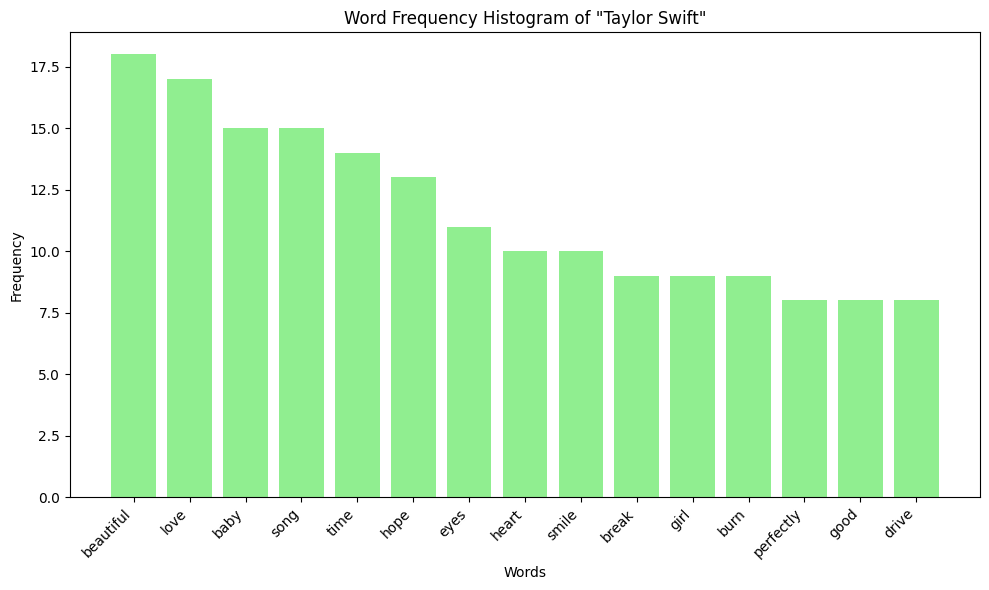

In [20]:
#join all the cleaned songs into their album
taylorswift_string = aperfectlygoodheart_string + aplaceinthisworld_string + coldasyou_string + imonlymewhenimwithyou_string + invisible_string + maryssong_string + oursong_string + picturetoburn_string + shouldvesaidno_string + staybeautiful_string + teardropsonmyguitar_string + theoutside_string + tiedtogetherwithasmile_string + timmcgraw_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
taylorswift_words = TweetTokenizer().tokenize(taylorswift_string)

#eliminate the stopwords
stop_words = ["€","im","…","uh","uhuh","yeah","ooh","ha","ohoh","™","weve", "hey","ive","youll","didnt", "wouldve","isnt","ill","dont","wanna","gonna","shouldve","0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings", "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc", "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning", "consequently", "consider", "considering", "contain", "containing", "contains", "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr", "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec", "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el", "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere", "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj", "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly", "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here", "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself", "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home", "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later", "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall", "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par", "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent", "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively", "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're", "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves", "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz",]
taylorswift_filtered_words = [word for word in taylorswift_words if word not in stop_words]

#counting the words
taylorswift_word_count=Counter(taylorswift_filtered_words)

#sorting the word_count from the most frequent word
taylorswift_word_count = dict(sorted(taylorswift_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
taylorswift_top_15_words = list(taylorswift_word_count.keys())[:15]
taylorswift_top_15_counts = [taylorswift_word_count[word] for word in taylorswift_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(taylorswift_top_15_words, taylorswift_top_15_counts, color="lightgreen")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "Taylor Swift"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Fearless

In [21]:
#process each song
breathe_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/Breathe_TaylorsVersion_.txt")
byebyebaby_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/ByeByeBaby_TaylorsVersion__FromtheVault_.txt")
change_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/Change_TaylorsVersion_.txt")
comewiththerain_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/ComeInWithTheRain_TaylorsVersion_.txt")
dontyou_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/DontYou_TaylorsVersion__FromtheVault_.txt")
fearless_song_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/Fearless_TaylorsVersion_.txt")
fifteen_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/Fifteen_TaylorsVersion_.txt")
foreverandalways_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/Forever_Always_TaylorsVersion_.txt")
heystephen_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/HeyStephen_TaylorsVersion_.txt")
jumpthenfall_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/JumpThenFall_TaylorsVersion_.txt")
lovestory_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/LoveStory_TaylorsVersion_.txt")
mrperfectlyfine_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/Mr_PerfectlyFine_TaylorsVersion__FromtheVault_.txt")
superstar_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/Superstar_TaylorsVersion_.txt")
tellmewhy_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/TellMeWhy_TaylorsVersion_.txt")
thatswhen_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/ThatsWhen_TaylorsVersion__FromtheVault_.txt")
thebestday_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/TheBestDay_TaylorsVersion_.txt")
theothersideofthedoor_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/TheOtherSideoftheDoor_TaylorsVersion_.txt")
thewayilovedyou_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/TheWayILovedYou_TaylorsVersion_.txt")
todaywasafairytale_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/TodayWasaFairytale_TaylorsVersion_.txt")
untouchable_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/Untouchable_TaylorsVersion_.txt")
wewerehappy_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/WeWereHappy_TaylorsVersion__FromtheVault_.txt")
whitehorse_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/WhiteHorse_TaylorsVersion_.txt")
youalloverme_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/YouAllOverMe_TaylorsVersion__FromtheVault_.txt")
youbelongwithme_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/YouBelongWithMe_TaylorsVersion_.txt")
yourenotsorry_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Fearless_TaylorsVersion_/YoureNotSorry_TaylorsVersion_.txt")

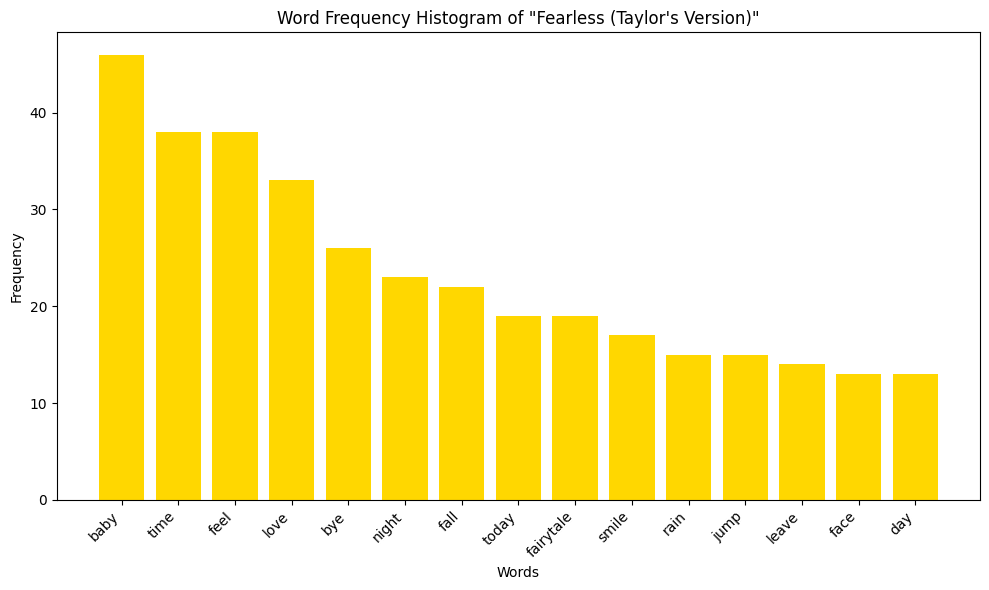

In [22]:
fearless_string = breathe_string + byebyebaby_string + change_string + comewiththerain_string + dontyou_string + fearless_song_string + fifteen_string + foreverandalways_string + heystephen_string + jumpthenfall_string + lovestory_string + mrperfectlyfine_string + superstar_string + tellmewhy_string + thatswhen_string + thebestday_string + thewayilovedyou_string + theothersideofthedoor_string + todaywasafairytale_string + untouchable_string + wewerehappy_string + whitehorse_string + youalloverme_string + youbelongwithme_string + yourenotsorry_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
fearless_words = TweetTokenizer().tokenize(fearless_string)

#eliminate the stopwords
fearless_filtered_words = [word for word in fearless_words if word not in stop_words]

#counting the words
fearless_word_count=Counter(fearless_filtered_words)

#sorting the word_count from the most frequent word
fearless_word_count = dict(sorted(fearless_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
fearless_top_15_words = list(fearless_word_count.keys())[:15]
fearless_top_15_counts = [fearless_word_count[word] for word in fearless_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(fearless_top_15_words, fearless_top_15_counts, color="gold")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "Fearless (Taylor\'s Version)"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Speak Now

In [23]:
#process each song
backtodecember_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/BackToDecember_TaylorsVersion_.txt")
betterthanrevenge_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/BetterThanRevenge_TaylorsVersion_.txt")
castlescrumbling_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/CastlesCrumbling_TaylorsVersion__FromTheVault_.txt")
dearjohn_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/DearJohn_TaylorsVersion_.txt")
electrictouch_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/ElectricTouch_TaylorsVersion__FromTheVault_.txt")
enchanted_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/Enchanted_TaylorsVersion_.txt")
foolishone_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/FoolishOne_TaylorsVersion__FromTheVault_.txt")
haunted_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/Haunted_TaylorsVersion_.txt")
icanseeyou_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/ICanSeeYou_TaylorsVersion__FromTheVault_.txt")
innocent_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/Innocent_TaylorsVersion_.txt")
lastkiss_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/LastKiss_TaylorsVersion_.txt")
longlive_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/LongLive_TaylorsVersion_.txt")
mean_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/Mean_TaylorsVersion_.txt")
mine_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/Mine_TaylorsVersion_.txt")
nevergrowup_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/NeverGrowUp_TaylorsVersion_.txt")
ours_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/Ours_TaylorsVersion_.txt")
sparksfly_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/SparksFly_TaylorsVersion_.txt")
speaknow_song_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/SpeakNow_TaylorsVersion_.txt")
superman_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/Superman_TaylorsVersion_.txt")
thestoryofus_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/TheStoryofUs_TaylorsVersion_.txt")
timeless_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/Timeless_TaylorsVersion__FromTheVault_.txt")
whenemmafallsinlove_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/SpeakNow_TaylorsVersion_/WhenEmmaFallsinLove_TaylorsVersion__FromTheVault_.txt")

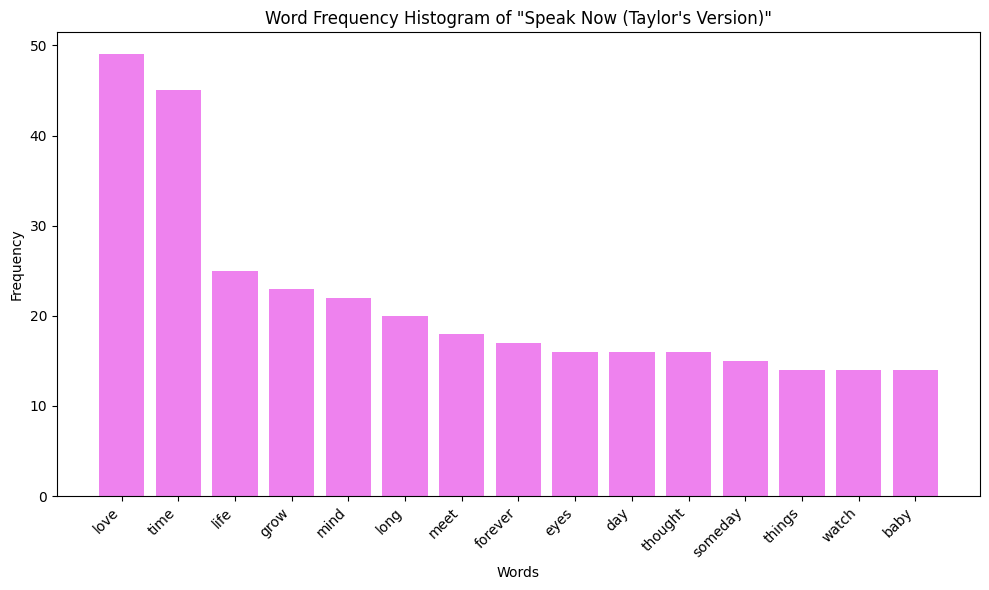

In [24]:
speaknow_string = backtodecember_string + betterthanrevenge_string + castlescrumbling_string + dearjohn_string + electrictouch_string + enchanted_string + foolishone_string + haunted_string + icanseeyou_string + innocent_string + lastkiss_string + longlive_string + mean_string + mine_string + ours_string + nevergrowup_string + sparksfly_string + speaknow_song_string + superman_string + thestoryofus_string + timeless_string + whenemmafallsinlove_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
speaknow_words = TweetTokenizer().tokenize(speaknow_string)

#eliminate the stopwords
speaknow_filtered_words = [word for word in speaknow_words if word not in stop_words]

#counting the words
speaknow_word_count=Counter(speaknow_filtered_words)

#sorting the word_count from the most frequent word
speaknow_word_count = dict(sorted(speaknow_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
speaknow_top_15_words = list(speaknow_word_count.keys())[:15]
speaknow_top_15_counts = [speaknow_word_count[word] for word in speaknow_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(speaknow_top_15_words, speaknow_top_15_counts, color="violet")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "Speak Now (Taylor\'s Version)"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Red

In [25]:
#process each song
twentytwo_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/22_TaylorsVersion_.txt")
alltoowell_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/AllTooWell_10MinuteVersion__TaylorsVersion__FromtheVault_.txt")
babe_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/Babe_TaylorsVersion__FromtheVault_.txt")
beginagain_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/BeginAgain_TaylorsVersion_.txt")
betterman_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/BetterMan_TaylorsVersion__FromtheVault_.txt")
comebackbehere_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/ComeBack___BeHere_TaylorsVersion_.txt")
everythinghaschanged_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/EverythingHasChanged_TaylorsVersion_.txt")
foreverwinter_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/ForeverWinter_TaylorsVersion__FromtheVault_.txt")
girlathome_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/GirlAtHome_TaylorsVersion_.txt")
holyground_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/HolyGround_TaylorsVersion_.txt")
ialmostdo_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/IAlmostDo_TaylorsVersion_.txt")
ibetyouthinkaboutme_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/IBetYouThinkAboutMe_TaylorsVersion__FromtheVault_.txt")
iknewyouweretrouble_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/IKnewYouWereTrouble_TaylorsVersion_.txt")
messageinabottle_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/MessageInABottle_TaylorsVersion__FromtheVault_.txt")
nothingnew_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/NothingNew_TaylorsVersion__FromtheVault_.txt")
red_song_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/Red_TaylorsVersion_.txt")
ronan_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/Ronan_TaylorsVersion_.txt")
run_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/Run_TaylorsVersion__FromtheVault_.txt")
sadbeautifultragic_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/SadBeautifulTragic_TaylorsVersion_.txt")
starlight_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/Starlight_TaylorsVersion_.txt")
stateofgrace_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/StateofGrace_TaylorsVersion_.txt")
staystaystay_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/StayStayStay_TaylorsVersion_.txt")
thelasttime_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/TheLastTime_TaylorsVersion_.txt")
theluckyone_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/TheLuckyOne_TaylorsVersion_.txt")
themomentiknew_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/TheMomentIKnew_TaylorsVersion_.txt")
theveryfirstnight_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/TheVeryFirstNight_TaylorsVersion__FromtheVault_.txt")
treacherous_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/Treacherous_TaylorsVersion_.txt")
weareneverevergettingbacktogether_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Red_TaylorsVersion_/WeAreNeverEverGettingBackTogether_TaylorsVersion_.txt")

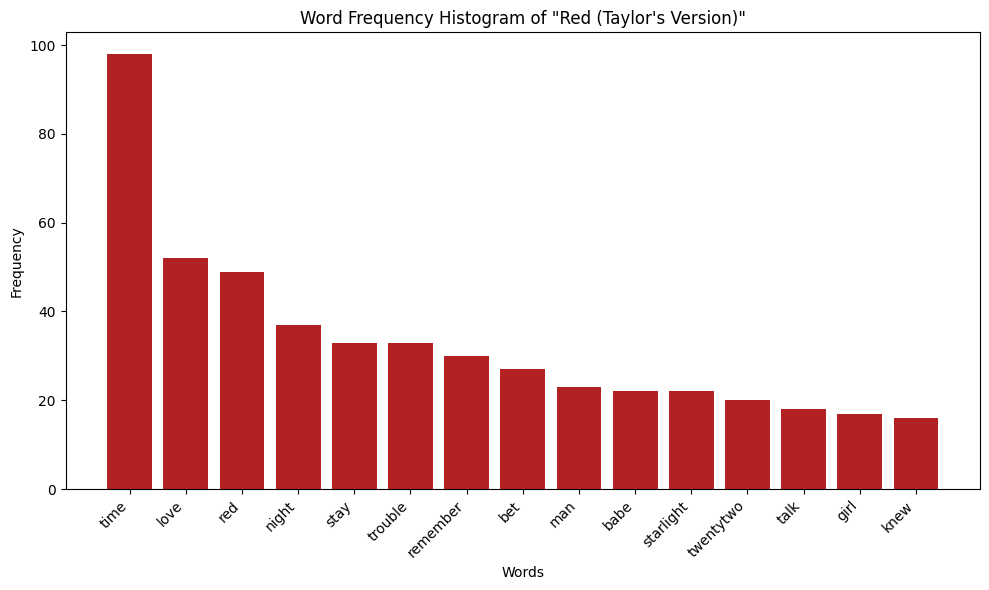

In [26]:
red_string = twentytwo_string + alltoowell_string + babe_string + beginagain_string + betterman_string + comebackbehere_string + everythinghaschanged_string + foreverwinter_string + girlathome_string + holyground_string + ialmostdo_string + ibetyouthinkaboutme_string + iknewyouweretrouble_string + messageinabottle_string + nothingnew_string + red_song_string + ronan_string + run_string + sadbeautifultragic_string + starlight_string + stateofgrace_string + staystaystay_string + thelasttime_string + theluckyone_string + themomentiknew_string + theveryfirstnight_string + treacherous_string + weareneverevergettingbacktogether_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
red_words = TweetTokenizer().tokenize(red_string)

#eliminate the stopwords
red_filtered_words = [word for word in red_words if word not in stop_words]

#counting the words
red_word_count=Counter(red_filtered_words)

#sorting the word_count from the most frequent word
red_word_count = dict(sorted(red_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
red_top_15_words = list(red_word_count.keys())[:15]
red_top_15_counts = [red_word_count[word] for word in red_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(red_top_15_words, red_top_15_counts, color="firebrick")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "Red (Taylor\'s Version)"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### 1989

In [27]:
#process each song
allyouhadtodowasstay_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/AllYouHadtoDoWasStay.txt")
badblood_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/BadBlood.txt")
blankspace_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/BlankSpace.txt")
clean_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/Clean.txt")
howyougetthegirl_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/HowYouGetTheGirl.txt")
iknowplaces_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/IKnowPlaces.txt")
iwhishyouwould_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/IWishYouWould.txt")
outofthewoods_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/OutOfTheWoods.txt")
shakeitoff_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/ShakeItOff.txt")
style_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/Style.txt")
thislove_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/ThisLove.txt")
welcometonewyork_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/WelcometoNewYork.txt")
wildestdreams_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/1989/WildestDreams.txt")

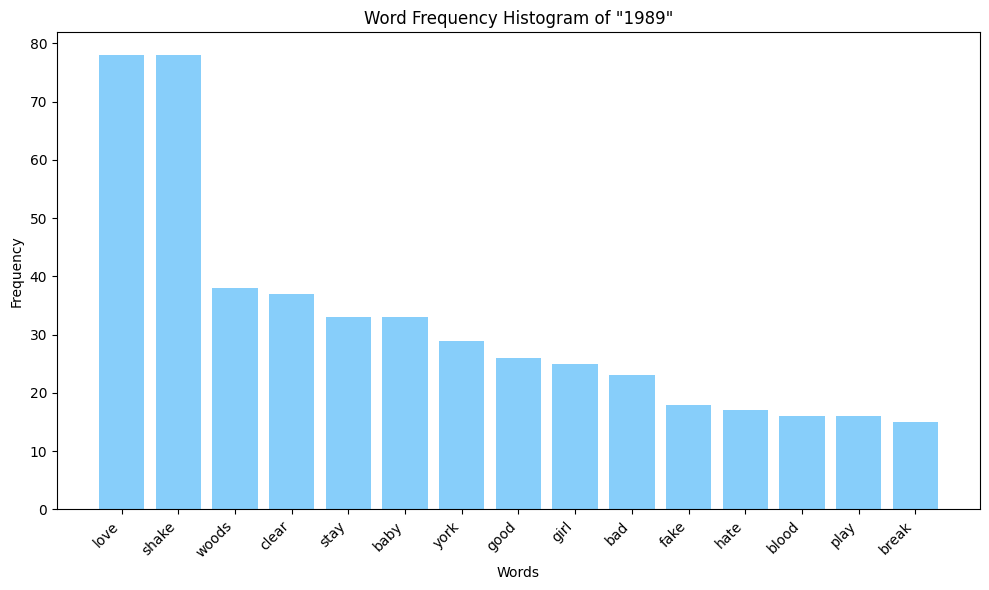

In [28]:
ninteeneightynine_string = allyouhadtodowasstay_string + badblood_string + blankspace_string + clean_string + howyougetthegirl_string + iknowplaces_string + iwhishyouwould_string + outofthewoods_string + shakeitoff_string + style_string + thislove_string + welcometonewyork_string + wildestdreams_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
ninteeneightynine_words = TweetTokenizer().tokenize(ninteeneightynine_string)

#eliminate the stopwords
ninteeneightynine_filtered_words = [word for word in ninteeneightynine_words if word not in stop_words]

#counting the words
ninteeneightynine_word_count=Counter(ninteeneightynine_filtered_words)

#sorting the word_count from the most frequent word
ninteeneightynine_word_count = dict(sorted(ninteeneightynine_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
ninteeneightynine_top_15_words = list(ninteeneightynine_word_count.keys())[:15]
ninteeneightynine_top_15_counts = [ninteeneightynine_word_count[word] for word in ninteeneightynine_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(ninteeneightynine_top_15_words, ninteeneightynine_top_15_counts, color="lightskyblue")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "1989"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Reputation 

In [29]:
#process each song
readyforit_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/___ReadyforIt_.txt")
callitwhatyouwant_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/CallItWhatYouWant.txt")
dancingwithourhandstied_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/DancingWithOurHandsTied.txt")
delicate_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/Delicate.txt")
dontblameme_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/DontBlameMe.txt")
dress_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/Dress.txt")
endgame_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/EndGame.txt")
getawaycar_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/GetawayCar.txt")
gorgeous_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/Gorgeous.txt")
ididsomethingbad_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/IDidSomethingBad.txt")
kingofmyheart_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/KingofMyHeart.txt")
lookwhatyoumademedo_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/LookWhatYouMadeMeDo.txt")
newyearsday_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/NewYearsDay.txt")
soitgoes_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/SoItGoes___.txt")
thisiswhywecanthavenicethings_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Reputation/ThisIsWhyWeCantHaveNiceThings.txt")

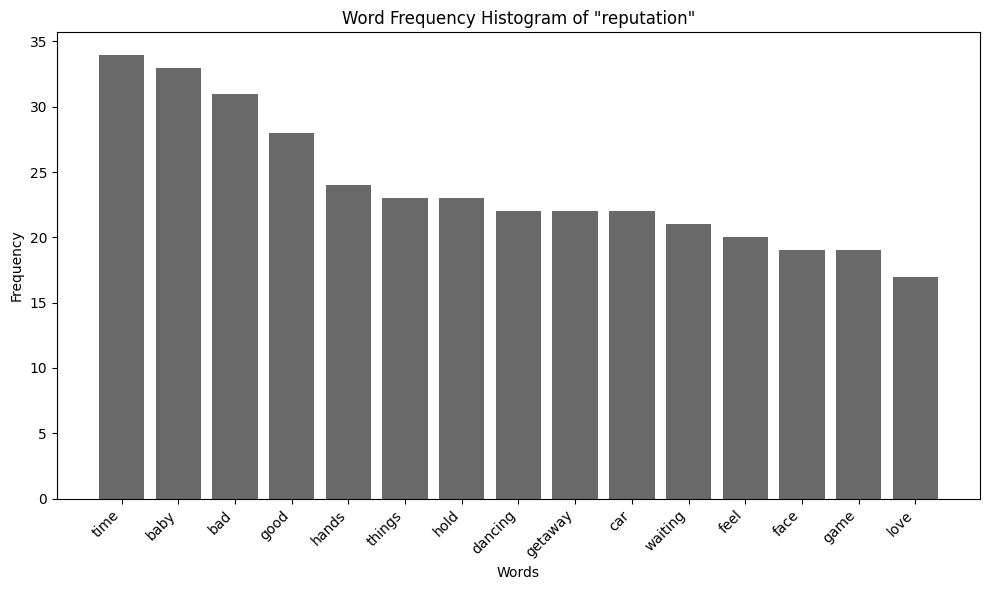

In [30]:
reputation_string = readyforit_string + callitwhatyouwant_string + dancingwithourhandstied_string + delicate_string + dontblameme_string + dress_string + endgame_string + getawaycar_string + gorgeous_string + ididsomethingbad_string + kingofmyheart_string + lookwhatyoumademedo_string + newyearsday_string + soitgoes_string + thisiswhywecanthavenicethings_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
reputation_words = TweetTokenizer().tokenize(reputation_string)

#eliminate the stopwords
reputation_filtered_words = [word for word in reputation_words if word not in stop_words]

#counting the words
reputation_word_count=Counter(reputation_filtered_words)

#sorting the word_count from the most frequent word
reputation_word_count = dict(sorted(reputation_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
reputation_top_15_words = list(reputation_word_count.keys())[:15]
reputation_top_15_counts = [reputation_word_count[word] for word in reputation_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(reputation_top_15_words, reputation_top_15_counts, color="dimgrey")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "reputation"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Lover

In [31]:
#process each song
afterglow_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/Afterglow.txt")
corneliastreet_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/CorneliaStreet.txt")
cruelsummer_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/CruelSummer.txt")
daylight_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/Daylight.txt")
deathbyathousandcuts_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/DeathbyaThousandCuts.txt")
falsegod_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/FalseGod.txt")
iforgotthatyouexisted_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/IForgotThatYouExisted.txt")
ithinkheknows_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/IThinkHeKnows.txt")
itsnicetohaveafriend_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/ItsNicetoHaveaFriend.txt")
londonboy_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/LondonBoy.txt")
lover_song_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/Lover.txt")
me_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/ME_.txt")
missamericanaandtheheartbreakprince_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/MissAmericana_TheHeartbreakPrince.txt")
paperrings_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/PaperRings.txt")
soonyoullgetbetter_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/SoonYoullGetBetter.txt")
thearcher_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/TheArcher.txt")
theman_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/TheMan.txt")
youneedtocalmdown_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Lover/YouNeedToCalmDown.txt")

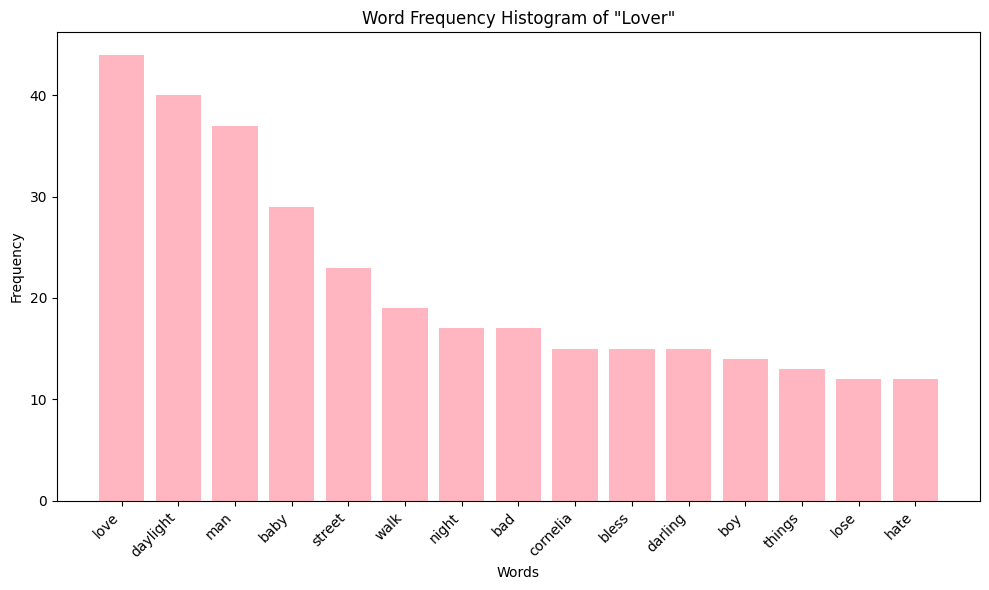

In [32]:
lover_string = afterglow_string + corneliastreet_string + cruelsummer_string + daylight_string + deathbyathousandcuts_string + falsegod_string + iforgotthatyouexisted_string + ithinkheknows_string + itsnicetohaveafriend_string + londonboy_string + lover_song_string + me_string + missamericanaandtheheartbreakprince_string + paperrings_string + soonyoullgetbetter_string + thearcher_string + theman_string + youneedtocalmdown_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
lover_words = TweetTokenizer().tokenize(lover_string)

#eliminate the stopwords
lover_filtered_words = [word for word in lover_words if word not in stop_words]

#counting the words
lover_word_count=Counter(lover_filtered_words)

#sorting the word_count from the most frequent word
lover_word_count = dict(sorted(lover_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
lover_top_15_words = list(lover_word_count.keys())[:15]
lover_top_15_counts = [lover_word_count[word] for word in lover_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(lover_top_15_words, lover_top_15_counts, color="lightpink")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "Lover"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### folklore

In [33]:
#process each song
august_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/august.txt")
betty_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/betty.txt")
cardigan_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/cardigan.txt")
epiphany_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/epiphany.txt")
exile_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/exile.txt")
hoax_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/hoax.txt")
illicitaffairs_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/illicitaffairs.txt")
invisiblestring_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/invisiblestring.txt")
madwoman_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/madwoman.txt")
mirrorball_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/mirrorball.txt")
mytearsricochet_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/mytearsricochet.txt")
peace_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/peace.txt")
seven_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/seven.txt")
the1_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/the1.txt")
thelastgreatamericandynasty_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/thelastgreatamericandynasty.txt")
thisismetrying_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/folklore/thisismetrying.txt")

### folklore lyrics

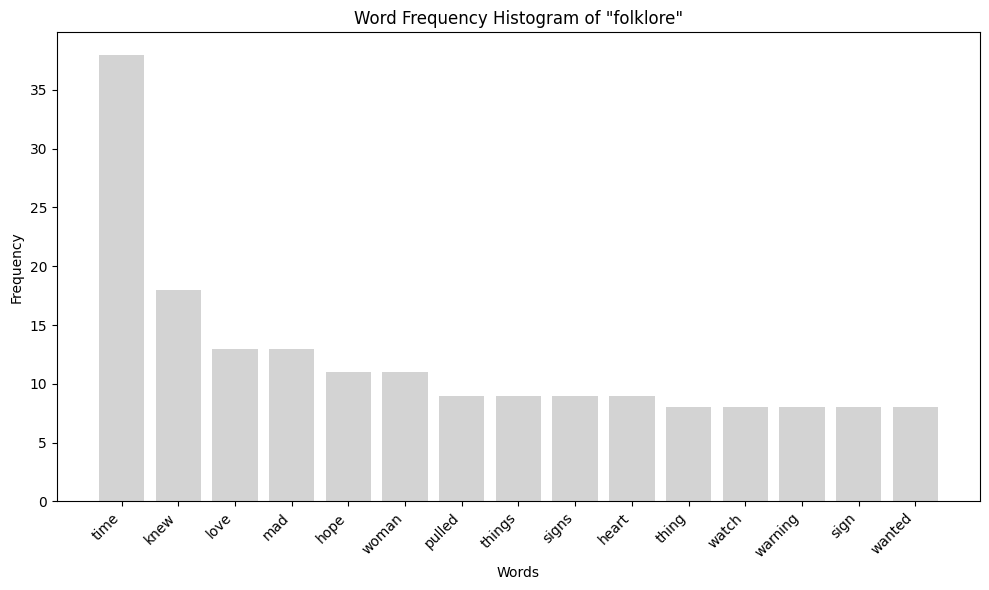

In [34]:
folklore_string = august_string + betty_string + cardigan_string + epiphany_string + exile_string + hoax_string + illicitaffairs_string + invisiblestring_string + madwoman_string + mirrorball_string + mytearsricochet_string + peace_string + seven_string + the1_string + thelastgreatamericandynasty_string + thisismetrying_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
folklore_words = TweetTokenizer().tokenize(folklore_string)

#eliminate the stopwords
folklore_filtered_words = [word for word in folklore_words if word not in stop_words]

#counting the words
folklore_word_count=Counter(folklore_filtered_words)

#sorting the word_count from the most frequent word
folklore_word_count = dict(sorted(folklore_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
folklore_top_15_words = list(folklore_word_count.keys())[:15]
folklore_top_15_counts = [folklore_word_count[word] for word in folklore_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(folklore_top_15_words, folklore_top_15_counts, color="lightgrey")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "folklore"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### evermore

In [35]:
#process each song
champagneproblems_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/champagneproblems.txt")
closure_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/closure.txt")
coneyisland_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/coneyisland.txt")
cowboylikeme_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/cowboylikeme.txt")
dorothea_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/dorothea.txt")
evermore_song_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/evermore.txt")
goldrush_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/goldrush.txt")
happiness_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/happiness.txt")
ivy_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/ivy.txt")
longstoryshort_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/longstoryshort.txt")
marjorie_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/marjorie.txt")
nobodynocrime_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/nobody_nocrime.txt")
tisthedamnseason_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/tisthedamnseason.txt")
tolerateit_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/tolerateit.txt")
willow_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Evermore/willow.txt")

### evermore Lyrics

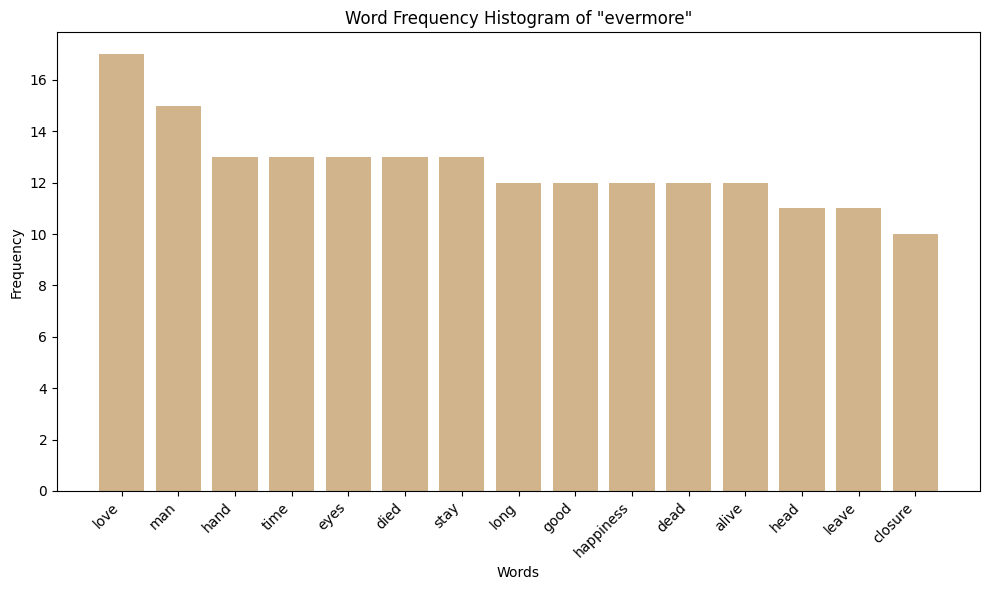

In [36]:
evermore_string = champagneproblems_string + closure_string + coneyisland_string + cowboylikeme_string + dorothea_string + evermore_song_string + goldrush_string + happiness_string + ivy_string + longstoryshort_string + marjorie_string + nobodynocrime_string + tisthedamnseason_string + tolerateit_string + willow_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
evermore_words = TweetTokenizer().tokenize(evermore_string)

#eliminate the stopwords
evermore_filtered_words = [word for word in evermore_words if word not in stop_words]

#counting the words
evermore_word_count=Counter(evermore_filtered_words)

#sorting the word_count from the most frequent word
evermore_word_count = dict(sorted(evermore_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
evermore_top_15_words = list(evermore_word_count.keys())[:15]
evermore_top_15_counts = [evermore_word_count[word] for word in evermore_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(evermore_top_15_words, evermore_top_15_counts, color="tan")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "evermore"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Midnights

In [37]:
#process each song
antihero_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/Anti_Hero.txt")
bejeweled_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/Bejeweled.txt")
karma_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/Karma.txt")
labyrinth_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/Labyrinth.txt")
lavenderhaze_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/LavenderHaze.txt")
maroon_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/Maroon.txt")
mastermind_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/Mastermind.txt")
midnightrain_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/MidnightRain.txt")
question_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/Question____.txt")
snowonthebeach_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/SnowOnTheBeach.txt")
sweetnothing_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/SweetNothing.txt")
vigilanteshit_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/VigilanteShit.txt")
youreonyourownkid_string = process_lyrics("/Users/camil/Documents/Uni/Magistrale/Social media web analytics/Project/Lyrics/Midnights/YoureOnYourOwn_Kid.txt")

### Midnights Lyrics

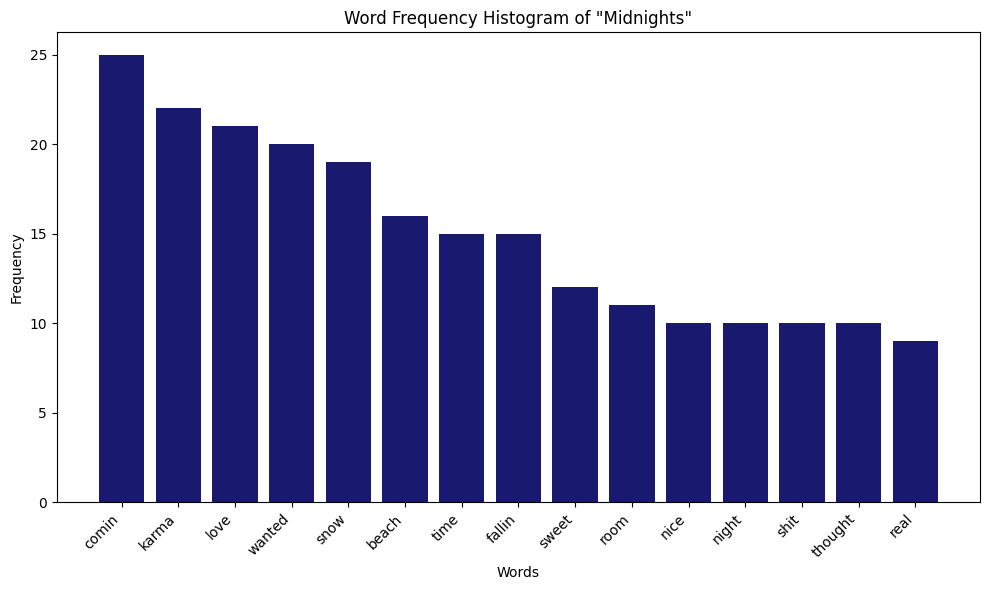

In [38]:
midnights_string = antihero_string + bejeweled_string + karma_string + labyrinth_string + lavenderhaze_string + maroon_string + mastermind_string + midnightrain_string + question_string + snowonthebeach_string + sweetnothing_string + vigilanteshit_string + youreonyourownkid_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
midnights_words = TweetTokenizer().tokenize(midnights_string)

#eliminate the stopwords
midnights_filtered_words = [word for word in midnights_words if word not in stop_words]

#counting the words
midnights_word_count=Counter(midnights_filtered_words)

#sorting the word_count from the most frequent word
midnights_word_count = dict(sorted(midnights_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
midnights_top_15_words = list(midnights_word_count.keys())[:15]
midnights_top_15_counts = [midnights_word_count[word] for word in midnights_top_15_words]

#plot the barplot
plt.figure(figsize=(10, 6))
plt.bar(midnights_top_15_words, midnights_top_15_counts, color="midnightblue")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of "Midnights"')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### All of the albums

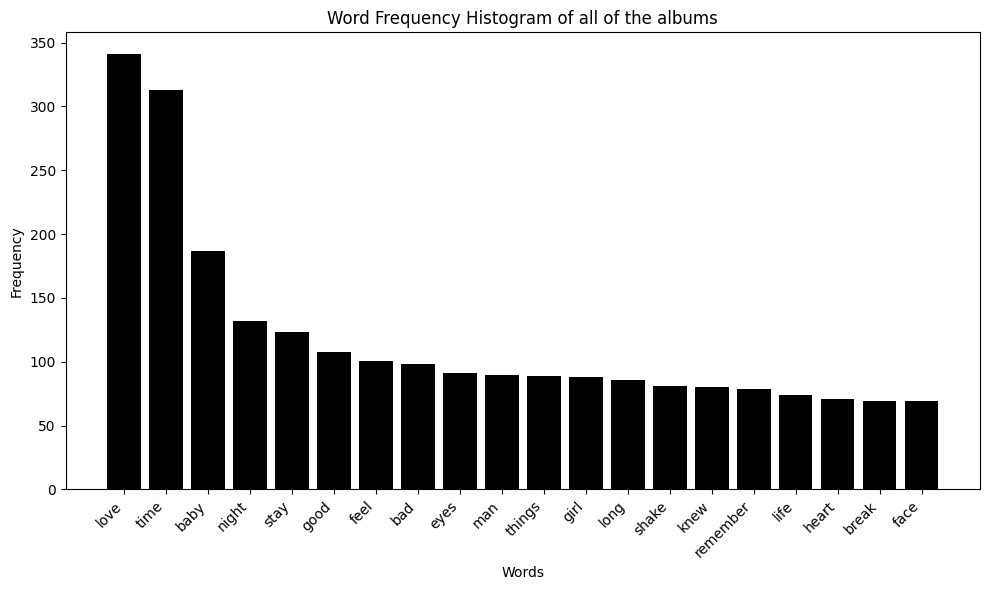

In [39]:
#join all the albums
allalbums_string = taylorswift_string + fearless_string + speaknow_string + red_string + ninteeneightynine_string + reputation_string + lover_string + folklore_string + evermore_string + midnights_string

#tokenize the words using the TweetTokenizer, it works better with colloquial/informal speech
allalbums_words = TweetTokenizer().tokenize(allalbums_string)

#eliminate the stopwords
allalbums_filtered_words = [word for word in allalbums_words if word not in stop_words]

#counting the words
allalbums_word_count=Counter(allalbums_filtered_words)

#sorting the word_count from the most frequent word
allalbums_word_count = dict(sorted(allalbums_word_count.items(), key=lambda item: item[1], reverse=True))

#only keep the 15 most frequent words
allalbums_top_15_words = list(allalbums_word_count.keys())[:20]
allalbums_top_15_counts = [allalbums_word_count[word] for word in allalbums_top_15_words]

plt.figure(figsize=(10, 6))
plt.bar(allalbums_top_15_words, allalbums_top_15_counts, color="black")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Word Frequency Histogram of all of the albums')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

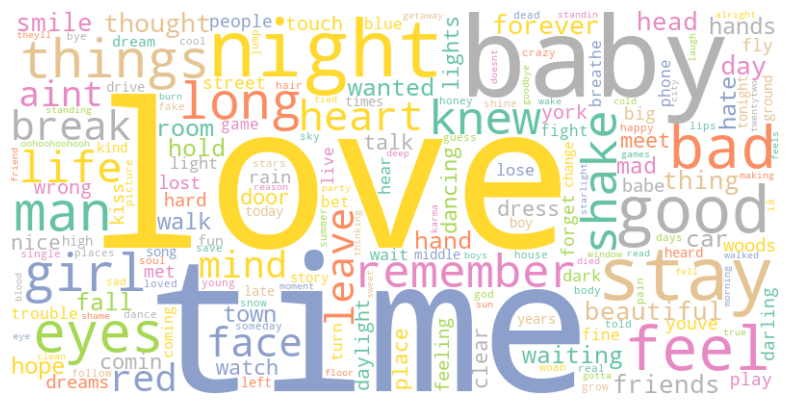

In [40]:
word_frequencies = Counter(allalbums_filtered_words)

wordcloud1 = WordCloud(width=800, height=400, colormap="Set2", min_font_size=8, relative_scaling=1, background_color="white").generate_from_frequencies(word_frequencies)

# Display the wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Colours analysis**

In [41]:
# A list of all possible colours that could be found during the analysis
allcolors = ['red', 'blue', 'green', 'yellow', 'purple', 'pink', 'orange', 'brown', 'black', 'white', 'cyan', 'maroon', 'beige', 'teal', 'indigo', 'magenta', 'violet', 'khaki', 'salmon', 'crimson', 'lavender', 'plum', 'grey', 'silver', 'gold', 'golden', 'amaranth', 'amethyst', 'aqua', 'aquamarine', 'azure', 'coral', 'bronze', 'lilac', 'burgundy', 'celeste', 'cerise', 'cerulean', 'charcoal', 'chestnut', 'citrine', 'claret', 'copper', 'cordovan', 'cream', 'crimson', 'cyclamen', 'dandelion', 'ebony', 'ecru', 'eggplant', 'eggshell', 'emerald', 'eminence', 'fallow', 'fandango', 'fawn', 'finn', 'flax', 'fuchsia', 'mauve', 'indigo', 'ivory', 'jasmine', 'khaki', 'lemon', 'periwinkle', 'lilac', 'salmon', 'scarlet', 'lime', 'magenta', 'mint', 'mahogany', 'malachite', 'mandarin', 'taupe', 'carmine', 'melon', 'mulberry', 'raspberry', 'cherry', 'ochre', 'rose', 'onyx', 'opal', 'orchid', 'peach', 'persimmon', 'pistachio', 'platinum', 'plum', 'prune', 'rubine', 'sage', 'sepia', 'sienna', 'tan', 'teal', 'turquoise', 'vermillion', ]

In [42]:
albums = ["Taylor Swift", "Fearless (Taylor's Version)", "Speak Now (Taylor's Version)", "Red (Taylor's Version)", "1989", "reputation", "Lover", "folklore", "evermore", "Midnights"]

#list of album strings
album_strings = [taylorswift_string, fearless_string, speaknow_string, red_string, ninteeneightynine_string, reputation_string, lover_string, folklore_string, evermore_string, midnights_string] # Add other album strings to the list

#initialize a dictionary to store color counts per album
color_counts_per_album = {album: {color: album_string.split().count(color) for color in allcolors} for album, album_string in zip(albums, album_strings)}

#filter out colors with zero occurrences for each album
color_counts_per_album_filtered = {album: {color: count for color, count in color_count.items() if count > 0} for album, color_count in color_counts_per_album.items()}

#display the results
for album, color_count in color_counts_per_album_filtered.items():
    print(f"Album: {album}")
    for color, count in color_count.items():
        print(f"{color}: {count} occurrences")
    print()

Album: Taylor Swift
blue: 6 occurrences
black: 3 occurrences
golden: 3 occurrences

Album: Fearless (Taylor's Version)
black: 1 occurrences
white: 6 occurrences
gold: 1 occurrences
scarlet: 1 occurrences

Album: Speak Now (Taylor's Version)
blue: 1 occurrences
green: 3 occurrences
brown: 1 occurrences
black: 1 occurrences
white: 3 occurrences
golden: 1 occurrences

Album: Red (Taylor's Version)
red: 49 occurrences
blue: 8 occurrences
green: 2 occurrences
black: 1 occurrences
golden: 1 occurrences
rose: 1 occurrences

Album: 1989
red: 7 occurrences
blue: 1 occurrences
green: 1 occurrences
black: 2 occurrences
white: 3 occurrences
cherry: 1 occurrences
rose: 1 occurrences

Album: reputation
red: 4 occurrences
blue: 3 occurrences
black: 5 occurrences
white: 1 occurrences
crimson: 1 occurrences
gold: 2 occurrences
golden: 3 occurrences
rose: 2 occurrences

Album: Lover
red: 2 occurrences
blue: 11 occurrences
pink: 1 occurrences
orange: 1 occurrences
black: 1 occurrences
white: 1 occurrence

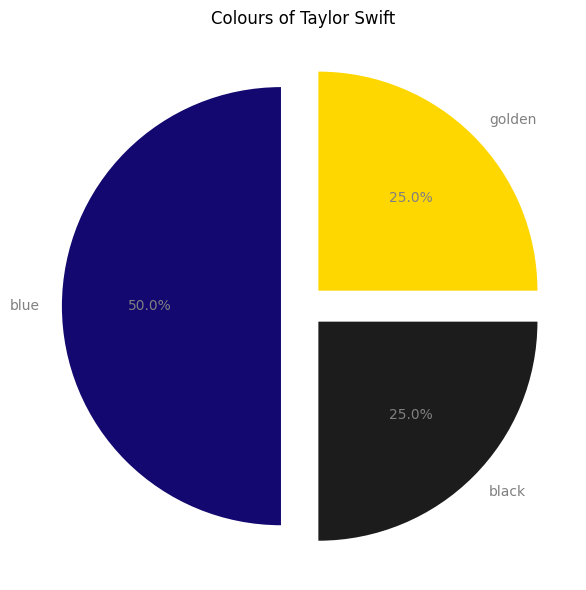

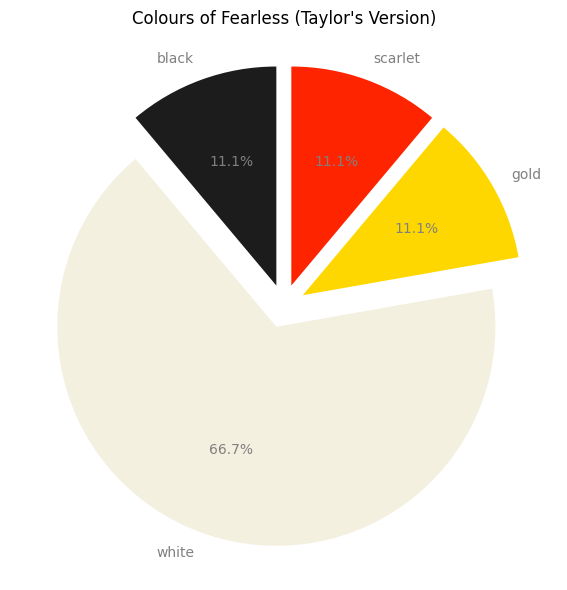

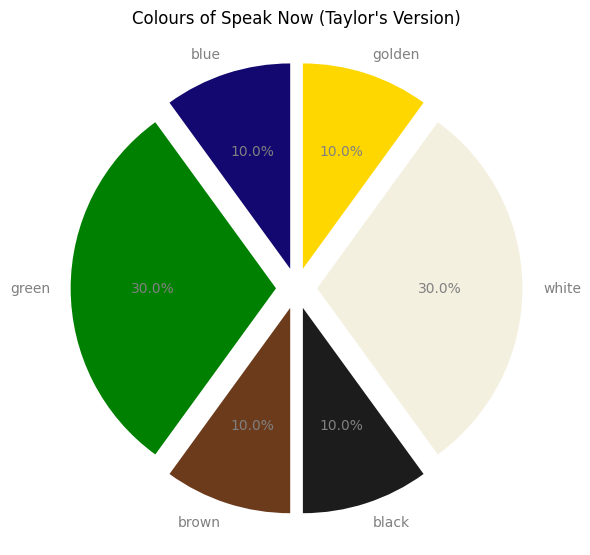

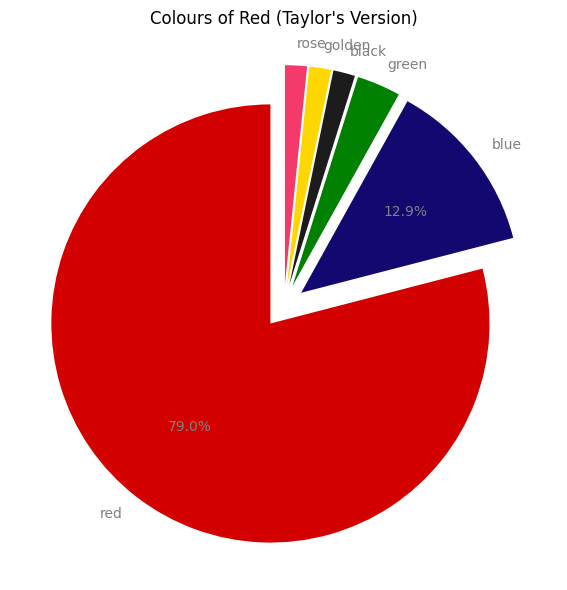

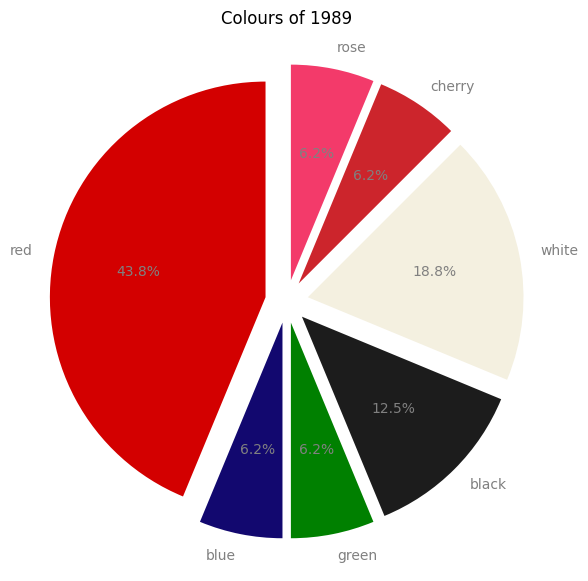

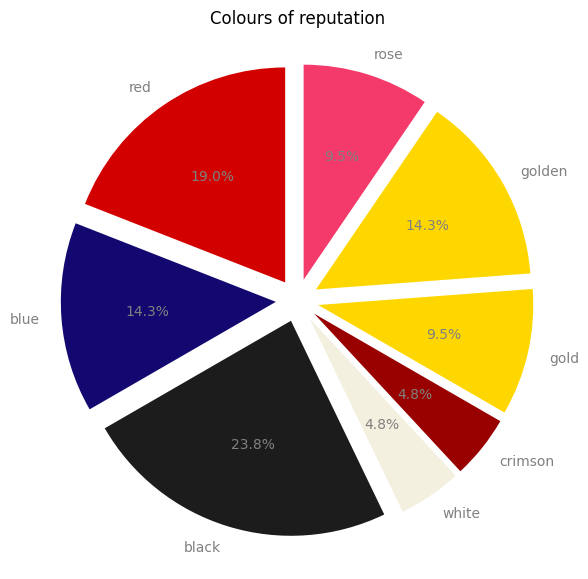

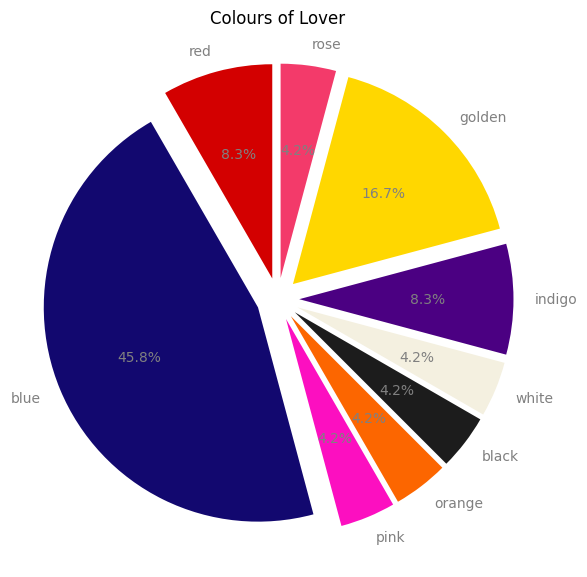

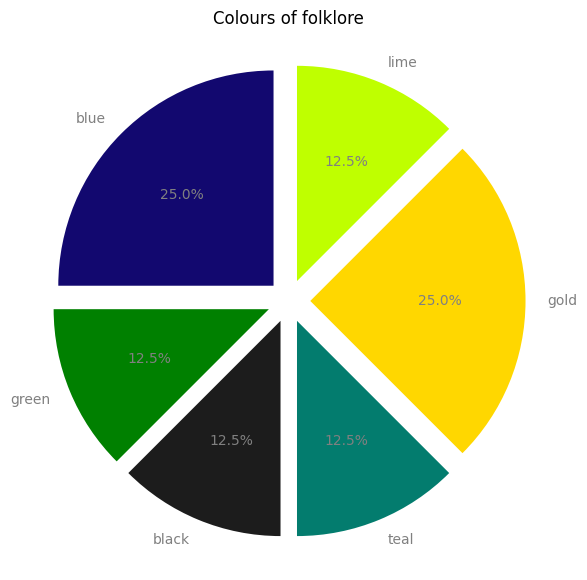

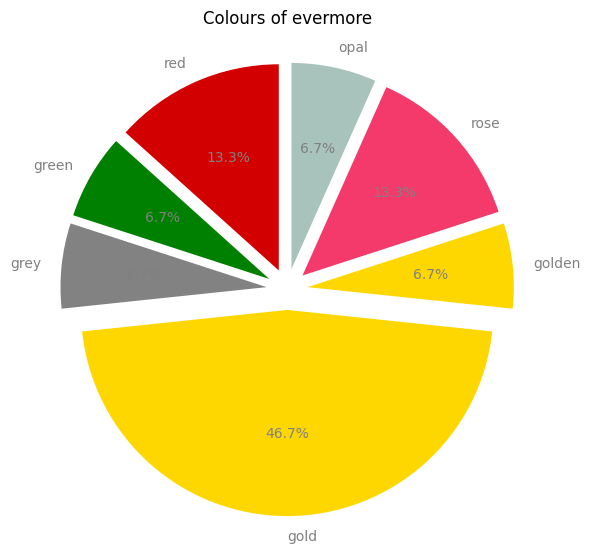

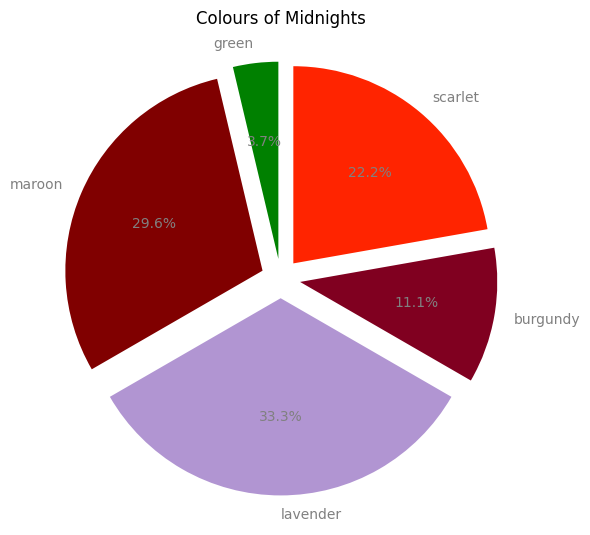

In [43]:
# A list of valid matplotlib color names
valid_colors = CSS4_COLORS.keys()

# Custom color replacements and mappings for missing colors
custom_color_map = {
    'tan': '#D2B48C',
    'rose': '#F33A6A',
    'golden': '#ffd700',
    'gold': '#ffd700',
    'black': '#1c1c1c',
    'blue': '#12086f',
    'red': '#d30000',
    'scarlet': '#FF2400',
    'cream': '#fffdd0',
    'white': '#f4f0e0',
    'teal': '#037C6E',
    'brown': '#6C3B1C',
    'green': '#008000',
    'sage': '#87ae73',
    'silver': '#D8D8D8',
    'cherry': '#CC252C',
    'lime':'#BFFF00',
    'crimson': '#990000',
    'indigo': '#4B0082',
    'orange': '#FC6600',
    'pink': '#FC0FC0',
    'opal': '#A8C3BC',
    'grey': '#828282',
    'burgundy': '#800020',
    'maroon': '#800000',
    'lavender': '#b195d2'
}

# Custom function to format percentage labels
def custom_autopct(pct):
    return f'{pct:.1f}%' if pct >= 3.5 else ''  # Show percentage if it's 3.5% or more


# Loop through the filtered color counts dictionary to create pie charts for each album
for album, color_count in color_counts_per_album_filtered.items():
    # Extract the colors and their counts for the current album
    colors = list(color_count.keys())
    counts = list(color_count.values())
    
    # Map the color names to their corresponding custom or CSS4 colors
    color_values = [
        custom_color_map[color] if color in custom_color_map
        else CSS4_COLORS[color] if color in valid_colors
        else '#000000'  # Default to black if the color is unrecognized
        for color in colors
    ]
    explode = [0.1] * len(colors)
    # Check if there are valid colors to plot
    if len(colors) > 0:
        # Create a pie chart for the album
        plt.figure(figsize=(6, 6))
        plt.pie(counts, labels=colors, autopct=custom_autopct, startangle=90, colors=color_values, explode=explode, textprops={'color': 'grey'})
        
        plt.title(f"Colours of {album}")
        
        plt.tight_layout()
        plt.show()

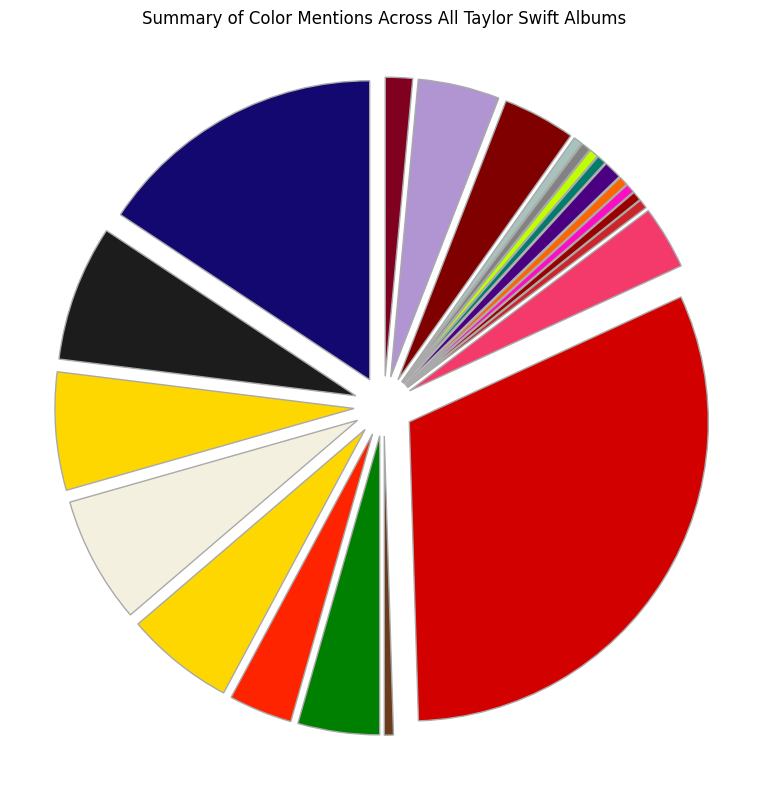

In [44]:
# Aggregate all color counts into a single dictionary
aggregated_color_counts = {}
for color_count in color_counts_per_album_filtered.values():
    for color, count in color_count.items():
        if color in aggregated_color_counts:
            aggregated_color_counts[color] += count
        else:
            aggregated_color_counts[color] = count

# Prepare data for the final pie chart
colors = list(aggregated_color_counts.keys())
counts = list(aggregated_color_counts.values())

# Map the color names to their corresponding custom or CSS4 colors
color_values = [
    custom_color_map[color] if color in custom_color_map
    else CSS4_COLORS[color] if color in valid_colors
    else '#000000'  # Default to black if the color is unrecognized
    for color in colors
]
def get_labels_for_pie(colors, counts):
    total = sum(counts)
    return [
        f"{color}" if (count / total) * 100 >= 2 else ""  # Show color name only if >= 3.5%
        for color, count in zip(colors, counts)
    ]

# Generate labels based on the 3.5% threshold
final_labels = get_labels_for_pie(colors, counts)
# Create the final summary pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, startangle=90, colors=color_values, explode=[0.1] * len(colors), textprops={'color': 'black'}, wedgeprops={'edgecolor': 'darkgrey'})
plt.title("Summary of Color Mentions Across All Taylor Swift Albums")
plt.tight_layout()
plt.show()

## **Positive/Negative sentiment analysis**

In [45]:
#setting up the analyzer that will tell us if a song is considered positive or negative

analyzer = SentimentIntensityAnalyzer() 

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    # The sentiment will be 1 (positive) if the compound score is >= 0, otherwise 0 (negative)
    sentiment = 1 if scores['compound'] >= 0 else 0
    return sentiment, scores

In [46]:
taylorswift_songs = {
    "A Perfectly Good Heart": aperfectlygoodheart_string,
    "A Place in This World": aplaceinthisworld_string,
    "Cold As You": coldasyou_string,
    "I'm Only Me When I'm With You": imonlymewhenimwithyou_string,
    "Invisible": invisible_string,
    "Mary's Song": maryssong_string,
    "Our Song": oursong_string,
    "Picture to Burn": picturetoburn_string,
    "Should've Said No": shouldvesaidno_string,
    "Stay Beautiful": staybeautiful_string,
    "Teardrops on My Guitar": teardropsonmyguitar_string,
    "The Outside": theoutside_string,
    "Tied Together With a Smile": tiedtogetherwithasmile_string,
    "Tim McGraw": timmcgraw_string
}

sentiments_taylorswift = []
for title, lyrics in taylorswift_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_taylorswift.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Save the compound score
    })

# Create a DataFrame
df = pd.DataFrame(sentiments_taylorswift)

# Sort the DataFrame based on the compound score
df_taylorswift_sorted = df.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame
print(df_taylorswift_sorted)


                            Title Sentiment  Compound Score
9                  Stay Beautiful  Positive          0.9988
0          A Perfectly Good Heart  Positive          0.9980
13                     Tim McGraw  Positive          0.9976
4                       Invisible  Positive          0.9900
5                     Mary's Song  Positive          0.9876
6                        Our Song  Positive          0.9623
10         Teardrops on My Guitar  Positive          0.9522
3   I'm Only Me When I'm With You  Positive          0.8793
12     Tied Together With a Smile  Negative         -0.3603
1           A Place in This World  Negative         -0.7821
8               Should've Said No  Negative         -0.8402
11                    The Outside  Negative         -0.8627
2                     Cold As You  Negative         -0.9299
7                 Picture to Burn  Negative         -0.9970


In [47]:
fearless_songs = {
    "Breathe": breathe_string,
    "Bye Bye Baby": byebyebaby_string,
    "Change": change_string,
    "Come With the Rain": comewiththerain_string,
    "Don't You": dontyou_string,
    "Fearless": fearless_song_string,
    "Fifteen": fifteen_string,
    "Forever & Always": foreverandalways_string,
    "Hey Stephen": heystephen_string,
    "Jump Then Fall": jumpthenfall_string,
    "Love Story": lovestory_string,
    "Mr. Perfectly Fine": mrperfectlyfine_string,
    "Superstar": superstar_string,
    "Tell Me Why": tellmewhy_string,
    "That's When": thatswhen_string,
    "The Best Day": thebestday_string,
    "The Way I Loved You": thewayilovedyou_string,
    "The Other Side of the Door": theothersideofthedoor_string,
    "Today Was a Fairytale": todaywasafairytale_string,
    "Untouchable": untouchable_string,
    "We Were Happy": wewerehappy_string,
    "White Horse": whitehorse_string,
    "You All Over Me": youalloverme_string,
    "You Belong With Me": youbelongwithme_string,
    "You're Not Sorry": yourenotsorry_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_fearless = []
for title, lyrics in fearless_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_fearless.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_fearless = pd.DataFrame(sentiments_fearless)

# Sort the DataFrame based on the compound score
df_fearless_sorted = df_fearless.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_fearless_sorted)


                         Title Sentiment  Compound Score
5                     Fearless  Positive          0.9988
15                The Best Day  Positive          0.9981
19                 Untouchable  Positive          0.9976
24            You're Not Sorry  Positive          0.9974
0                      Breathe  Positive          0.9967
16         The Way I Loved You  Positive          0.9956
12                   Superstar  Positive          0.9951
20               We Were Happy  Positive          0.9935
2                       Change  Positive          0.9918
11          Mr. Perfectly Fine  Positive          0.9913
18       Today Was a Fairytale  Positive          0.9894
10                  Love Story  Positive          0.9892
6                      Fifteen  Positive          0.9845
23          You Belong With Me  Positive          0.9758
21                 White Horse  Positive          0.9416
22             You All Over Me  Positive          0.9218
4                    Don't You 

In [48]:
speaknow_songs = {
    "Back to December": backtodecember_string,
    "Better Than Revenge": betterthanrevenge_string,
    "Castles Crumbling": castlescrumbling_string,
    "Dear John": dearjohn_string,
    "Electric Touch": electrictouch_string,
    "Enchanted": enchanted_string,
    "Foolish One": foolishone_string,
    "Haunted": haunted_string,
    "I Can See You": icanseeyou_string,
    "Innocent": innocent_string,
    "Last Kiss": lastkiss_string,
    "Long Live": longlive_string,
    "Mean": mean_string,
    "Mine": mine_string,
    "Ours": ours_string,
    "Never Grow Up": nevergrowup_string,
    "Sparks Fly": sparksfly_string,
    "Speak Now": speaknow_song_string,
    "Superman": superman_string,
    "The Story of Us": thestoryofus_string,
    "Timeless": timeless_string,
    "When Emma Falls in Love": whenemmafallsinlove_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_speaknow = []
for title, lyrics in speaknow_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_speaknow.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_speaknow = pd.DataFrame(sentiments_speaknow)

# Sort the DataFrame based on the compound score
df_speaknow_sorted = df_speaknow.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_speaknow_sorted)

                      Title Sentiment  Compound Score
14                     Ours  Positive          0.9978
15            Never Grow Up  Positive          0.9970
10                Last Kiss  Positive          0.9963
13                     Mine  Positive          0.9962
0          Back to December  Positive          0.9959
21  When Emma Falls in Love  Positive          0.9955
5                 Enchanted  Positive          0.9951
6               Foolish One  Positive          0.9912
9                  Innocent  Positive          0.9841
20                 Timeless  Positive          0.9834
18                 Superman  Positive          0.9650
8             I Can See You  Positive          0.9626
19          The Story of Us  Positive          0.9570
16               Sparks Fly  Positive          0.9371
2         Castles Crumbling  Positive          0.7128
12                     Mean  Negative         -0.3020
17                Speak Now  Negative         -0.6955
4            Electric Touch 

In [49]:
red_songs = {
    "22": twentytwo_string,
    "All Too Well": alltoowell_string,
    "Babe": babe_string,
    "Begin Again": beginagain_string,
    "Better Man": betterman_string,
    "Come Back... Be Here": comebackbehere_string,
    "Everything Has Changed": everythinghaschanged_string,
    "Forever Winter": foreverwinter_string,
    "Girl at Home": girlathome_string,
    "Holy Ground": holyground_string,
    "I Almost Do": ialmostdo_string,
    "I Bet You Think About Me": ibetyouthinkaboutme_string,
    "I Knew You Were Trouble": iknewyouweretrouble_string,
    "Message in a Bottle": messageinabottle_string,
    "Nothing New": nothingnew_string,
    "Red": red_song_string,
    "Ronan": ronan_string,
    "Run": run_string,
    "Sad Beautiful Tragic": sadbeautifultragic_string,
    "Starlight": starlight_string,
    "State of Grace": stateofgrace_string,
    "Stay Stay Stay": staystaystay_string,
    "The Last Time": thelasttime_string,
    "The Lucky One": theluckyone_string,
    "The Moment I Knew": themomentiknew_string,
    "The Very First Night": theveryfirstnight_string,
    "Treacherous": treacherous_string,
    "We Are Never Ever Getting Back Together": weareneverevergettingbacktogether_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_red = []
for title, lyrics in red_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_red.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_red = pd.DataFrame(sentiments_red)

# Sort the DataFrame based on the compound score
df_red_sorted = df_red.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_red_sorted)


                                      Title Sentiment  Compound Score
4                                Better Man  Positive          0.9992
15                                      Red  Positive          0.9981
13                      Message in a Bottle  Positive          0.9977
6                    Everything Has Changed  Positive          0.9976
1                              All Too Well  Positive          0.9975
18                     Sad Beautiful Tragic  Positive          0.9973
23                            The Lucky One  Positive          0.9971
19                                Starlight  Positive          0.9965
0                                        22  Positive          0.9957
27  We Are Never Ever Getting Back Together  Positive          0.9954
17                                      Run  Positive          0.9944
11                 I Bet You Think About Me  Positive          0.9915
24                        The Moment I Knew  Positive          0.9911
21                  

In [50]:
nineteeneightynine_songs = {
    "All You Had to Do Was Stay": allyouhadtodowasstay_string,
    "Bad Blood": badblood_string,
    "Blank Space": blankspace_string,
    "Clean": clean_string,
    "How You Get the Girl": howyougetthegirl_string,
    "I Know Places": iknowplaces_string,
    "I Wish You Would": iwhishyouwould_string,
    "Out of the Woods": outofthewoods_string,
    "Shake It Off": shakeitoff_string,
    "Style": style_string,
    "This Love": thislove_string,
    "Welcome to New York": welcometonewyork_string,
    "Wildest Dreams": wildestdreams_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_nineteeneightynine = []
for title, lyrics in nineteeneightynine_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_nineteeneightynine.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_nineteeneightynine = pd.DataFrame(sentiments_nineteeneightynine)

# Sort the DataFrame based on the compound score
df_nineteeneightynine_sorted = df_nineteeneightynine.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_nineteeneightynine_sorted)

                         Title Sentiment  Compound Score
10                   This Love  Positive          0.9999
7             Out of the Woods  Positive          0.9995
11         Welcome to New York  Positive          0.9995
0   All You Had to Do Was Stay  Positive          0.9967
12              Wildest Dreams  Positive          0.9961
9                        Style  Positive          0.9910
3                        Clean  Positive          0.9685
5                I Know Places  Positive          0.1518
4         How You Get the Girl  Negative         -0.8591
2                  Blank Space  Negative         -0.9301
1                    Bad Blood  Negative         -0.9941
6             I Wish You Would  Negative         -0.9991
8                 Shake It Off  Negative         -0.9998


In [51]:
reputation_songs = {
    "...Ready for It?": readyforit_string,
    "Call It What You Want": callitwhatyouwant_string,
    "Dancing with Our Hands Tied": dancingwithourhandstied_string,
    "Delicate": delicate_string,
    "Don't Blame Me": dontblameme_string,
    "Dress": dress_string,
    "End Game": endgame_string,
    "Getaway Car": getawaycar_string,
    "Gorgeous": gorgeous_string,
    "I Did Something Bad": ididsomethingbad_string,
    "King of My Heart": kingofmyheart_string,
    "Look What You Made Me Do": lookwhatyoumademedo_string,
    "New Year's Day": newyearsday_string,
    "So It Goes...": soitgoes_string,
    "This Is Why We Can't Have Nice Things": thisiswhywecanthavenicethings_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_reputation = []
for title, lyrics in reputation_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_reputation.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_reputation = pd.DataFrame(sentiments_reputation)

# Sort the DataFrame based on the compound score
df_reputation_sorted = df_reputation.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_reputation_sorted)

                                    Title Sentiment  Compound Score
9                     I Did Something Bad  Positive          0.9990
1                   Call It What You Want  Positive          0.9988
14  This Is Why We Can't Have Nice Things  Positive          0.9984
3                                Delicate  Positive          0.9961
5                                   Dress  Positive          0.9959
13                          So It Goes...  Positive          0.9804
6                                End Game  Positive          0.9758
0                        ...Ready for It?  Positive          0.9702
10                       King of My Heart  Positive          0.9136
8                                Gorgeous  Positive          0.9104
12                         New Year's Day  Positive          0.9052
2             Dancing with Our Hands Tied  Positive          0.8807
7                             Getaway Car  Negative         -0.9826
4                          Don't Blame Me  Negat

In [52]:
lover_songs = {
    "Afterglow": afterglow_string,
    "Cornelia Street": corneliastreet_string,
    "Cruel Summer": cruelsummer_string,
    "Daylight": daylight_string,
    "Death by a Thousand Cuts": deathbyathousandcuts_string,
    "False God": falsegod_string,
    "I Forgot That You Existed": iforgotthatyouexisted_string,
    "I Think He Knows": ithinkheknows_string,
    "It's Nice to Have a Friend": itsnicetohaveafriend_string,
    "London Boy": londonboy_string,
    "Lover": lover_song_string,
    "ME!": me_string,
    "Miss Americana & The Heartbreak Prince": missamericanaandtheheartbreakprince_string,
    "Paper Rings": paperrings_string,
    "Soon You'll Get Better": soonyoullgetbetter_string,
    "The Archer": thearcher_string,
    "The Man": theman_string,
    "You Need To Calm Down": youneedtocalmdown_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_lover = []
for title, lyrics in lover_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_lover.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_lover = pd.DataFrame(sentiments_lover)

# Sort the DataFrame based on the compound score
df_lover_sorted = df_lover.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_lover_sorted)


                                     Title Sentiment  Compound Score
9                               London Boy  Positive          0.9996
5                                False God  Positive          0.9985
13                             Paper Rings  Positive          0.9966
11                                     ME!  Positive          0.9964
7                         I Think He Knows  Positive          0.9957
3                                 Daylight  Positive          0.9953
8               It's Nice to Have a Friend  Positive          0.9952
10                                   Lover  Positive          0.9946
17                   You Need To Calm Down  Positive          0.9937
14                  Soon You'll Get Better  Positive          0.9918
6                I Forgot That You Existed  Positive          0.9714
15                              The Archer  Positive          0.9485
1                          Cornelia Street  Positive          0.9110
4                 Death by a Thous

In [53]:
folklore_songs = {
    "August": august_string,
    "Betty": betty_string,
    "Cardigan": cardigan_string,
    "Epiphany": epiphany_string,
    "Exile": exile_string,
    "Hoax": hoax_string,
    "Illicit Affairs": illicitaffairs_string,
    "Invisible String": invisiblestring_string,
    "Mad Woman": madwoman_string,
    "Mirrorball": mirrorball_string,
    "My Tears Ricochet": mytearsricochet_string,
    "Peace": peace_string,
    "Seven": seven_string,
    "The 1": the1_string,
    "The Last Great American Dynasty": thelastgreatamericandynasty_string,
    "This Is Me Trying": thisismetrying_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_folklore = []
for title, lyrics in folklore_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_folklore.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_folklore = pd.DataFrame(sentiments_folklore)

# Sort the DataFrame based on the compound score
df_folklore_sorted = df_folklore.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_folklore_sorted)


                              Title Sentiment  Compound Score
12                            Seven  Positive          0.9968
0                            August  Positive          0.9962
2                          Cardigan  Positive          0.9943
13                            The 1  Positive          0.9906
14  The Last Great American Dynasty  Positive          0.9801
1                             Betty  Positive          0.9643
3                          Epiphany  Positive          0.9562
7                  Invisible String  Positive          0.9463
9                        Mirrorball  Positive          0.9281
11                            Peace  Positive          0.4331
15                This Is Me Trying  Negative         -0.9190
4                             Exile  Negative         -0.9327
6                   Illicit Affairs  Negative         -0.9717
5                              Hoax  Negative         -0.9735
8                         Mad Woman  Negative         -0.9844
10      

In [54]:
evermore_songs = {
    "Champagne Problems": champagneproblems_string,
    "Closure": closure_string,
    "Coney Island": coneyisland_string,
    "Cowboy Like Me": cowboylikeme_string,
    "Dorothea": dorothea_string,
    "Evermore": evermore_song_string,
    "Gold Rush": goldrush_string,
    "Happiness": happiness_string,
    "Ivy": ivy_string,
    "Long Story Short": longstoryshort_string,
    "Marjorie": marjorie_string,
    "Nobody, No Crime": nobodynocrime_string,
    "'Tis the Damn Season": tisthedamnseason_string,
    "Tolerate It": tolerateit_string,
    "Willow": willow_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_evermore = []
for title, lyrics in evermore_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_evermore.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_evermore = pd.DataFrame(sentiments_evermore)

# Sort the DataFrame based on the compound score
df_evermore_sorted = df_evermore.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_evermore_sorted)


                   Title Sentiment  Compound Score
6              Gold Rush  Positive          0.9986
7              Happiness  Positive          0.9979
13           Tolerate It  Positive          0.9939
14                Willow  Positive          0.9822
1                Closure  Positive          0.9809
2           Coney Island  Positive          0.9370
10              Marjorie  Positive          0.8708
12  'Tis the Damn Season  Positive          0.4407
0     Champagne Problems  Positive          0.2349
9       Long Story Short  Negative         -0.3730
4               Dorothea  Negative         -0.8285
8                    Ivy  Negative         -0.8997
3         Cowboy Like Me  Negative         -0.9457
5               Evermore  Negative         -0.9917
11      Nobody, No Crime  Negative         -0.9980


In [55]:
midnights_songs = {
    "Antihero": antihero_string,
    "Bejeweled": bejeweled_string,
    "Karma": karma_string,
    "Labyrinth": labyrinth_string,
    "Lavender Haze": lavenderhaze_string,
    "Maroon": maroon_string,
    "Mastermind": mastermind_string,
    "Midnight Rain": midnightrain_string,
    "Question": question_string,
    "Snow on the Beach": snowonthebeach_string,
    "Sweet Nothing": sweetnothing_string,
    "Vigilante Shit": vigilanteshit_string,
    "You're On Your Own, Kid": youreonyourownkid_string
}

# Apply sentiment analysis to each song and store in a list of dictionaries
sentiments_midnights = []
for title, lyrics in midnights_songs.items():
    sentiment, scores = get_sentiment(lyrics)
    sentiments_midnights.append({
        "Title": title,
        "Sentiment": 'Positive' if sentiment == 1 else 'Negative',
        "Compound Score": scores['compound']  # Store only the compound score
    })

# Create a DataFrame
df_midnights = pd.DataFrame(sentiments_midnights)

# Sort the DataFrame based on the compound score
df_midnights_sorted = df_midnights.sort_values(by='Compound Score', ascending=False)

# Print the sorted DataFrame for the Fearless album
print(df_midnights_sorted)


                      Title Sentiment  Compound Score
9         Snow on the Beach  Positive          0.9985
7             Midnight Rain  Positive          0.9968
8                  Question  Positive          0.9958
12  You're On Your Own, Kid  Positive          0.9945
3                 Labyrinth  Positive          0.9942
1                 Bejeweled  Positive          0.9911
6                Mastermind  Positive          0.9609
10            Sweet Nothing  Positive          0.9558
11           Vigilante Shit  Positive          0.7745
4             Lavender Haze  Negative         -0.4497
2                     Karma  Negative         -0.7093
5                    Maroon  Negative         -0.9438
0                  Antihero  Negative         -0.9960


In [56]:
# List of DataFrames for each album
album_dfs = [df_taylorswift_sorted, df_fearless_sorted, df_speaknow_sorted, df_red_sorted, df_nineteeneightynine_sorted, df_reputation_sorted, df_lover_sorted, df_folklore_sorted, df_evermore_sorted, df_midnights_sorted]  # Add all your DataFrames here

df_taylorswift_sorted['Album'] = 'Taylor Swift'
df_fearless_sorted['Album'] = "Fearless (Taylor's Version)"
df_speaknow_sorted['Album'] = "Speak Now (Taylor's Version)"
df_red_sorted['Album'] = "Red (Taylor's Version)"
df_nineteeneightynine_sorted['Album'] = '1989'
df_reputation_sorted['Album'] = 'reputation'
df_lover_sorted['Album'] = 'Lover'
df_folklore_sorted['Album'] = 'folklore'
df_evermore_sorted['Album'] = 'evermore'
df_midnights_sorted['Album'] = 'Midnights'

# Combine DataFrames into one
df_combined = pd.concat(album_dfs, ignore_index=True)

# Sort the combined DataFrame based on positive sentiment scores
df_combined_sorted = df_combined.sort_values(by='Compound Score', ascending=False)

album_colors = {
    'Taylor Swift': 'lightgreen',
    "Fearless (Taylor's Version)": 'gold',
    "Speak Now (Taylor's Version)": 'violet',
    "Red (Taylor's Version)": 'firebrick',
    '1989': 'lightskyblue',
    'reputation': 'dimgrey',
    'Lover': 'lightpink',
    'folklore': 'lightgrey',
    'evermore': 'tan',
    'Midnights': 'midnightblue'
}

top_20_rows = df_combined_sorted.head(20)
styled_top_20_rows = top_20_rows.style.applymap(lambda album: f'background-color: {album_colors.get(album, "white")}', subset=['Album'])

# Display the styled top 20 rows
styled_top_20_rows

,Title,Sentiment,Compound Score,Album
89,This Love,Positive,0.999900,1989
117,London Boy,Positive,0.999600,Lover
91,Welcome to New York,Positive,0.999500,1989
90,Out of the Woods,Positive,0.999500,1989
61,Better Man,Positive,0.999200,Red (Taylor's Version)
102,I Did Something Bad,Positive,0.999000,reputation
14,Fearless,Positive,0.998800,Fearless (Taylor's Version)
103,Call It What You Want,Positive,0.998800,reputation
0,Stay Beautiful,Positive,0.998800,Taylor Swift
151,Gold Rush,Positive,0.998600,evermore


In [57]:
albums = {
    'Taylor Swift': df_taylorswift_sorted,
    "Fearless (Taylor's Version)": df_fearless_sorted,
    "Speak Now (Taylor's Version)": df_speaknow_sorted,
    "Red (Taylor's Version)": df_red_sorted,
    '1989': df_nineteeneightynine_sorted,
    'reputation': df_reputation_sorted,
    'Lover': df_lover_sorted,
    'folklore': df_folklore_sorted,
    'evermore': df_evermore_sorted,
    'Midnights': df_midnights_sorted
}

# Calculate a positive song rate (positive songs/total songs) for each album

for album_name, df in albums.items():
    positive_songs_count = len(df[df['Sentiment'] == 'Positive'])
    total_songs_count = len(df)

    positive_rate = positive_songs_count / total_songs_count

    print(f"The rate of positive songs in the '{album_name}' album is: {positive_rate:.2%}")

The rate of positive songs in the 'Taylor Swift' album is: 57.14%
The rate of positive songs in the 'Fearless (Taylor's Version)' album is: 80.00%
The rate of positive songs in the 'Speak Now (Taylor's Version)' album is: 68.18%
The rate of positive songs in the 'Red (Taylor's Version)' album is: 85.71%
The rate of positive songs in the '1989' album is: 61.54%
The rate of positive songs in the 'reputation' album is: 80.00%
The rate of positive songs in the 'Lover' album is: 77.78%
The rate of positive songs in the 'folklore' album is: 62.50%
The rate of positive songs in the 'evermore' album is: 60.00%
The rate of positive songs in the 'Midnights' album is: 69.23%


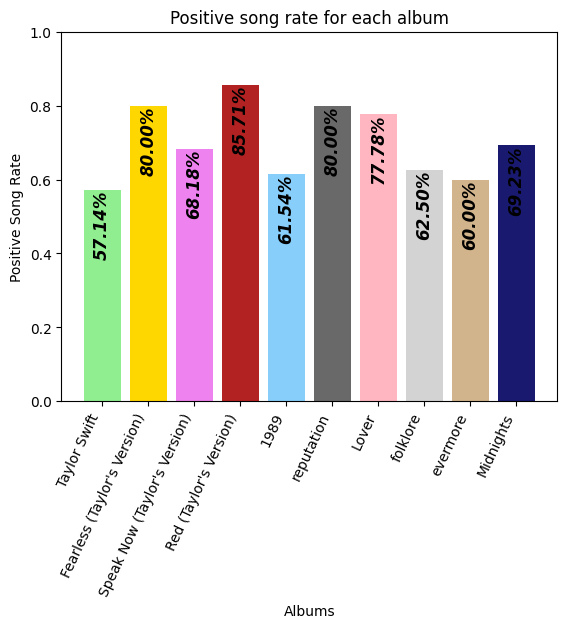

In [58]:
positive_rates = {
    'Taylor Swift': 0.5714,
    "Fearless (Taylor's Version)": 0.80,
    "Speak Now (Taylor's Version)": 0.6818,
    "Red (Taylor's Version)": 0.8571,
    '1989': 0.6154,
    'reputation': 0.8,
    'Lover': 0.7778,
    'folklore': 0.625,
    'evermore': 0.6,
    'Midnights': 0.6923
}

# Create a histogram with colors
fig, ax = plt.subplots()
bars = plt.bar(positive_rates.keys(), positive_rates.values(), color=[album_colors[album] for album in positive_rates.keys()])
plt.xlabel('Albums')
plt.ylabel('Positive Song Rate')
plt.title('Positive song rate for each album')
plt.ylim(0, 1)  # Set y-axis limit to represent percentage

# Rotate x-axis labels by 65 degrees
plt.xticks(rotation=65, ha='right')

# Annotate each bar with its percentage value
for bar, percentage in zip(bars, positive_rates.values()):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{percentage:.2%}', ha='center', rotation='vertical', va='top', fontfamily='sans-serif', fontweight=700, fontstyle='italic',fontsize=12)

plt.show()

In [59]:
def calculate_similarity(album1_lyrics, album2_lyrics):
    album1_words = set(album1_lyrics)  #converting the lyrics into a set to eliminate duplicates
    album2_words = set(album2_lyrics)
    common_words = album1_words.intersection(album2_words)  #finding which words appear in both albums
    return len(common_words)  #number of words in common

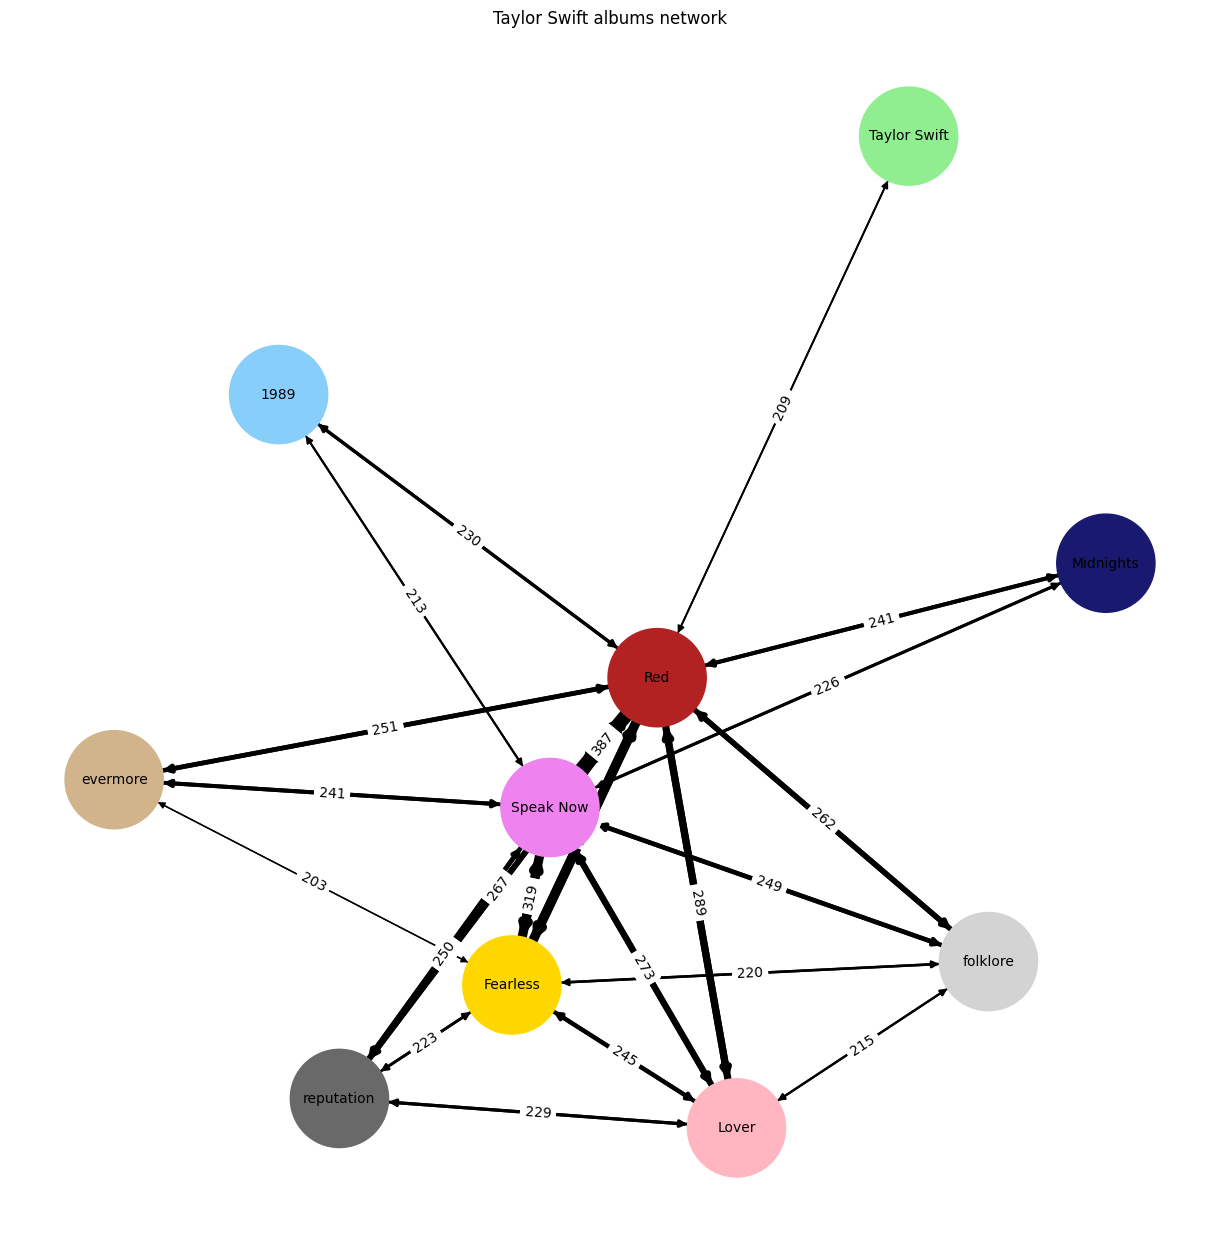

In [60]:
# List of albums and their corresponding filtered words
albums = {
    "Taylor Swift": taylorswift_filtered_words,
    "Fearless": fearless_filtered_words,
    "Lover": lover_filtered_words,
    "Speak Now": speaknow_filtered_words,
    "1989": ninteeneightynine_filtered_words,
    "reputation": reputation_filtered_words,
    "folklore": folklore_filtered_words,
    "evermore": evermore_filtered_words,
    "Midnights": midnights_filtered_words,
    "Red": red_filtered_words
}

album_colors_short = {             #without the "Taylor's Version" indication for Fearless, Speak Now and Red so that it's more readable in the network
    'Taylor Swift': 'lightgreen',
    "Fearless": 'gold',
    "Speak Now": 'violet',
    "Red": 'firebrick',
    '1989': 'lightskyblue',
    'reputation': 'dimgrey',
    'Lover': 'lightpink',
    'folklore': 'lightgrey',
    'evermore': 'tan',
    'Midnights': 'midnightblue'
}

#threshold for similarity, only albums with >200 words in common will be linked
threshold = 200

# Create the graph and calculate similarity between all pairs of albums
G = nx.DiGraph()
for album1, words1 in albums.items():
    for album2, words2 in albums.items():
        if album1 != album2:  #ensure not to compare the same album
            similarity = calculate_similarity(words1, words2)
            if similarity > threshold:  #check if similarity exceeds threshold
                G.add_edge(album1, album2, weight=similarity)

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

#minimum thickness for edges
minimum_width = 1

#determine the maximum and minimum weights
weights = [G[u][v]['weight'] for u, v in G.edges()]
max_weight = max(weights)
min_weight = min(weights)

#calculate normalized weights with minimum thickness considered
normalized_weights = [((weight - min_weight) / (max_weight - min_weight)) * (10 - minimum_width) + minimum_width for weight in weights]

#customized colors for each album
node_colors = [album_colors_short[album] for album in G.nodes]

nx.draw(G, pos, with_labels=True, node_size=5000, node_color=node_colors, font_size=10, width=normalized_weights)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Taylor Swift albums network")
plt.show()
